# Perform inference with trained yolo model

## Imports

In [1]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}"

In [2]:
from pathlib import Path
import cv2
import hydra
from hydra import compose, initialize
import supervision as sv
import numpy as np



In [3]:
import torch

# Setup device-agnostic code
if torch.cuda.is_available():
    DEVICE = "cuda"  # NVIDIA GPU
    print("GPU Found!!")
else:
    raise Exception("No GPU Found!!")

GPU Found!!


In [4]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## Paths setup

In [5]:
from omegaconf import DictConfig
import hydra
with initialize(config_path="../configs", job_name="EDA", version_base=None):
    cfg: DictConfig = compose(config_name="inference.yaml")
    # print(OmegaConf.to_yaml(cfg))
    print(cfg.paths)

{'root_dir': '${oc.env:PROJECT_ROOT}', 'root_data_dir': '${oc.env:DATA_ROOT}', 'results_dir': '${paths.root_dir}/results', 'log_dir': '${paths.root_dir}/logs/', 'output_dir': '${hydra:runtime.output_dir}', 'work_dir': '${hydra:runtime.cwd}', 'pretrained_model_dir': '${paths.root_dir}/pretrained_models', 'train_bst_model': '${paths.root_dir}/results/final_yolov11l_weights/best.pt', 'train_lst_model': '${paths.root_dir}/results/final_yolov11l_weights/last.pt'}


In [6]:
# auto reload libs
%load_ext autoreload
%autoreload 2

In [7]:
ROOT_DIR = Path(cfg.paths.root_dir)
ROOT_DATA_DIR = Path(cfg.paths.root_data_dir)
DATA_DIR = ROOT_DATA_DIR / cfg.datasets.datasets_dir
DATASET  = cfg.datasets.roboflow
DATA_DIR.mkdir(parents=True, exist_ok=True)
DATASET_DIR = DATA_DIR/ cfg.datasets.dataset_name
CLASS_NAMES = cfg.datasets.names
imgsz =  hydra.utils.instantiate(cfg.args.imgsz, _convert_="object")

In [8]:
TRAIN_BST_MODEL = cfg.paths.train_bst_model
TRAIN_LST_MODEL = cfg.paths.train_lst_model

## Download Datasets

In [9]:
if len(list(DATA_DIR.iterdir())) == 0:
    from roboflow import Roboflow

    rf = Roboflow()
    project = rf.workspace(DATASET.workspace).project(DATASET.project)
    version = project.version(DATASET.version)
    dataset = version.download(model_format=DATASET.model)

## YOLO model import

In [10]:
from ultralytics import YOLO
model = YOLO(TRAIN_BST_MODEL)

## Inference on Video

In [11]:
TEST_VIDEO = '/workspaces/football-players-tracking-yolo/data/0bfacc_0.mp4'

In [12]:
%matplotlib inline

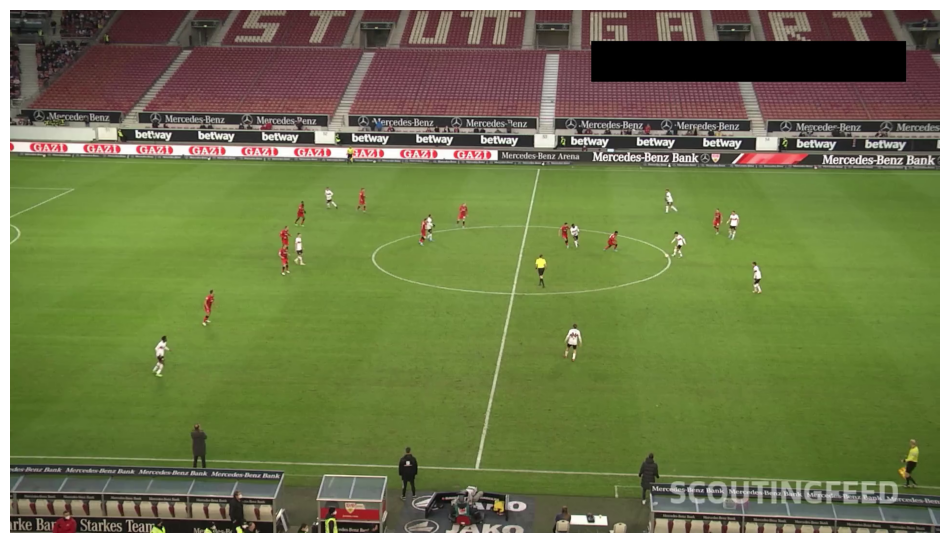

In [13]:
frame_generator = sv.get_video_frames_generator(TEST_VIDEO)
frame = next(frame_generator)
sv.plot_image(frame)

In [14]:
BALL_ID = 0
colors_list = [sv.Color.RED, sv.Color.WHITE, sv.Color.GREEN, sv.Color.BLUE]
colors = sv.ColorPalette(colors= colors_list)

# ellip_annotator = sv.EllipseAnnotator(color=colors,thickness=2)
ellip_annotator = sv.EllipseAnnotator(color=colors,thickness=2)
traingle_annot = sv.TriangleAnnotator(color=colors_list[0], 
                                      outline_thickness=2)
label_annotator = sv.LabelAnnotator(
    color=colors,
    text_color=sv.Color.BLACK,
    text_position=sv.Position.TOP_CENTER
)

In [15]:
# def _callback(image_slice: np.ndarray) -> sv.Detections:
#     # result = model(image_slice)[0]
#     result = model.predict(image_slice, conf=0.3)[0]
#     # result = model.predict(image_slice, imgsz=imgsz, conf=0.3)[0]
#     detections = sv.Detections.from_ultralytics(result)
#     return detections

# slicer = sv.InferenceSlicer(callback =_callback,
#                             # slice_wh=(512, 512),
#                             # overlap_wh=None, 
#                             # thread_workers=8
#                             )

# detections = slicer(frame)
# result = model.predict(frame, conf=0.3)[0]
result = model.predict(frame, imgsz=imgsz, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)
detections


0: 736x1280 21 players, 3 referees, 62.3ms
Speed: 9.9ms preprocess, 62.3ms inference, 105.6ms postprocess per image at shape (1, 3, 736, 1280)


Detections(xyxy=array([[     1142.3,      644.56,        1181,      726.63],
       [     1084.2,       501.4,      1108.3,      574.68],
       [     1835.6,      883.71,      1876.7,      987.15],
       [     293.44,      671.75,      332.15,      757.43],
       [      715.5,      367.34,       735.9,      418.62],
       [     1478.7,      412.83,      1505.7,      475.67],
       [     1531.6,      518.13,      1552.6,      586.56],
       [     397.67,      575.85,      421.44,      653.24],
       [     649.84,      364.02,      676.22,      413.67],
       [     1351.5,      368.12,      1378.7,      420.87],
       [     921.48,      397.32,      945.05,      451.76],
       [     1364.3,      454.61,      1396.3,      511.91],
       [     586.16,      458.92,      609.46,      528.73],
       [     586.94,      392.88,      611.24,      448.65],
       [       1450,      408.53,      1470.7,      465.14],
       [     1225.8,      455.17,      1255.5,      500.11],
       [

In [16]:
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

rest_detections = detections[detections.class_id != BALL_ID]
rest_detections= rest_detections.with_nms(threshold=0.5, class_agnostic=True)
rest_detections.class_id -=1

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]
frame = frame.copy()
annot_frame = ellip_annotator.annotate(scene=frame, detections=rest_detections)

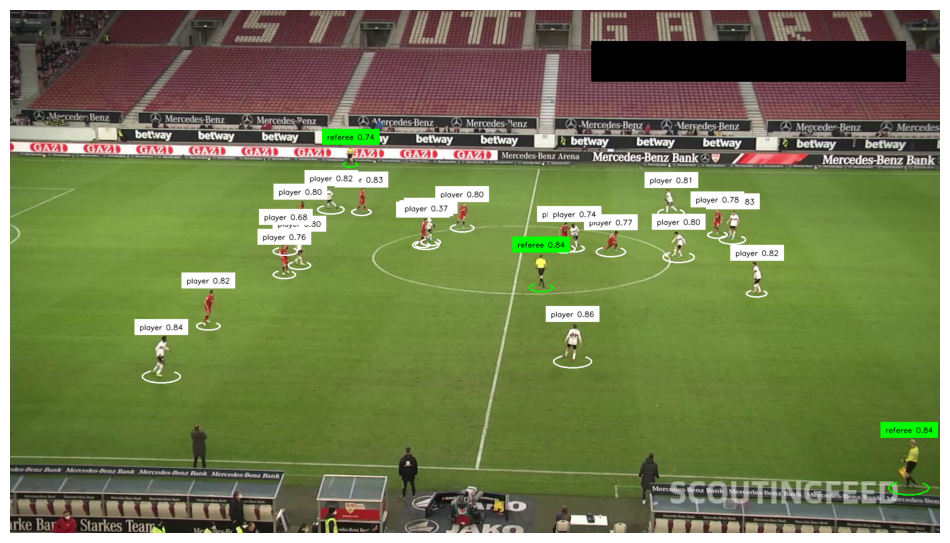

In [17]:
annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)
annotated_frame = label_annotator.annotate(
    scene=annot_frame,
    detections=rest_detections,
    labels=labels)
sv.plot_image(annot_frame)

In [18]:

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # https://hydra.cc/docs/advanced/instantiate_objects/overview/#parameter-conversion-strategies
    
    result = model.predict(frame, imgsz=imgsz, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    rest_detections = detections[detections.class_id != BALL_ID]
    rest_detections= rest_detections.with_nms(threshold=0.5, class_agnostic=True)
    rest_detections.class_id -=1

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence
        in zip(rest_detections['class_name'], detections.confidence)
    ]
    annot_frame = ellip_annotator.annotate(scene=frame.copy(), detections=rest_detections)
    annot_frame = label_annotator.annotate(scene=annot_frame,detections=rest_detections,labels=labels)
    annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)
    return annot_frame

# sv.process_video(
#     source_path=TEST_VIDEO,
#     target_path="/workspaces/football-players-tracking-yolo/results/result.mp4",
#     callback=callback
# )

In [19]:
import numpy as np


def callback_with_inferenceslicer(frame: np.ndarray, _: int) -> np.ndarray:
    # https://hydra.cc/docs/advanced/instantiate_objects/overview/#parameter-conversion-strategies
    def _callback(image_slice: np.ndarray) -> sv.Detections:
        # result = model(image_slice)[0]
        result = model.predict(image_slice, conf=0.3)[0]
        # result = model.predict(image_slice, imgsz=imgsz, conf=0.3)[0]
        detections = sv.Detections.from_ultralytics(result)
        return detections

    slicer = sv.InferenceSlicer(callback =_callback,
                            slice_wh=(360, 360),
                            thread_workers=64
                                )
    detections = slicer(frame)
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    rest_detections = detections[detections.class_id != BALL_ID]
    rest_detections= rest_detections.with_nms(threshold=0.5, class_agnostic=True)
    rest_detections.class_id -=1

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence
        in zip(rest_detections['class_name'], detections.confidence)
    ]
    annot_frame = ellip_annotator.annotate(scene=frame.copy(), detections=rest_detections)
    annot_frame = label_annotator.annotate(scene=annot_frame,detections=rest_detections,labels=labels)
    annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)
    return annot_frame

sv.process_video(
    source_path=TEST_VIDEO,
    target_path="/workspaces/football-players-tracking-yolo/results/result.mp4",
    callback=callback_with_inferenceslicer
)





























0: 1280x1280 (no detections), 71.3ms
Speed: 36.2ms preprocess, 71.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 62.9ms
Speed: 6.2ms preprocess, 62.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)


SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 61.0ms
Speed: 8.7ms preprocess, 61.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 72.7ms
Speed: 9.0ms preprocess, 72.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.8ms
Speed: 9.1ms preprocess, 58.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.6ms
Speed: 9.8ms preprocess, 57.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 74.6ms
Speed: 6.5ms preprocess, 74.6ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 61.9ms
Speed: 9.0ms preprocess, 61.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.6ms
Speed: 8.9ms preprocess, 58.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 59.7ms
Speed: 8.6ms prepro

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 65.0ms
Speed: 5.2ms preprocess, 65.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.6ms
Speed: 5.0ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.2ms
Speed: 4.9ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.1ms
Speed: 4.0ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 73.2ms
Speed: 5.1ms preprocess, 73.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.9ms
Speed: 4.6ms preprocess, 55.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 54.6ms
Speed: 4.3ms preprocess, 54.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 52.7ms
Speed: 4.7ms preprocess, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.1ms
Speed: 4.9ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.6ms
Speed: 5.7ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.8ms
Speed: 4.1ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 64.1ms
Speed: 3.0ms preprocess, 64.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.3ms
Speed: 4.0ms preprocess, 53.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.6ms
Speed: 4.0ms preprocess, 53.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 70.1ms
Speed: 4.1ms preprocess, 70.1ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 52.0ms
Speed: 4.6ms preprocess, 52.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.6ms
Speed: 4.4ms preprocess, 51.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 60.2ms
Speed: 2.9ms preprocess, 60.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.9ms
Speed: 4.2ms preprocess, 53.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 4 players, 52.9ms
Speed: 4.2ms preprocess, 52.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 52.3ms
Speed: 4.3ms preprocess, 52.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 66.3ms
Speed: 4.7ms preprocess

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.2ms
Speed: 4.4ms preprocess, 53.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.4ms
Speed: 5.0ms preprocess, 56.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.8ms
Speed: 3.2ms preprocess, 54.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 57.7ms
Speed: 5.8ms preprocess, 57.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 54.5ms
Speed: 4.6ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.0ms
Speed: 4.4ms preprocess, 54.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.2ms
Speed: 4.5ms preprocess, 55.2ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.5ms
Speed: 4.3ms preprocess, 54.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 64.0ms
Speed: 5.5ms preprocess, 64.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.7ms
Speed: 4.4ms preprocess, 55.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.0ms
Speed: 4.5ms preprocess, 58.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.7ms
Speed: 3.2ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 60.3ms
Speed: 5.7ms preprocess, 60.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 51.6ms
Speed: 4.3ms preprocess, 51.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.4ms
Speed: 4.5ms preprocess, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 58.3ms
Speed: 5.0ms preprocess, 58.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.0ms
Speed: 4.8ms preprocess, 58.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 4.5ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.8ms
Speed: 3.1ms preprocess, 51.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.7ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 52.1ms
Speed: 4.2ms preprocess, 52.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.5ms
Speed: 4.6ms preprocess, 55.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 51.6ms
Speed: 4.6ms preprocess, 51.6ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.7ms
Speed: 4.2ms preprocess, 55.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.4ms
Speed: 4.3ms preprocess, 53.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.8ms
Speed: 4.3ms preprocess, 52.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.1ms
Speed: 3.2ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.0ms
Speed: 4.1ms preprocess, 54.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.3ms
Speed: 4.0ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.4ms
Speed: 4.4ms preprocess, 54.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.9ms
Speed: 5.0ms preprocess, 53.9ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.4ms
Speed: 4.3ms preprocess, 51.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.7ms preprocess, 55.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.2ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.6ms
Speed: 2.9ms preprocess, 56.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.6ms
Speed: 4.5ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 56.1ms
Speed: 4.5ms preprocess, 56.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 52.6ms
Speed: 4.4ms preprocess, 52.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 57.0ms
Speed: 4.9ms preprocess, 57.0ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 50.6ms
Speed: 4.4ms preprocess, 50.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.6ms
Speed: 4.6ms preprocess, 52.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.2ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.3ms
Speed: 3.0ms preprocess, 52.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.2ms
Speed: 4.9ms preprocess, 54.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 52.9ms
Speed: 3.9ms preprocess, 52.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 51.0ms
Speed: 4.5ms preprocess, 51.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.3ms
Speed: 4.0ms preprocess, 53.3ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.3ms
Speed: 4.1ms preprocess, 55.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.8ms
Speed: 4.4ms preprocess, 51.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.8ms
Speed: 4.6ms preprocess, 56.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.0ms
Speed: 3.5ms preprocess, 55.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.2ms preprocess, 53.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.9ms
Speed: 4.9ms preprocess, 52.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.8ms
Speed: 4.5ms preprocess, 53.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.0ms
Speed: 4.1ms preprocess, 52.0ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 61.2ms
Speed: 4.2ms preprocess, 61.2ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.3ms
Speed: 4.7ms preprocess, 57.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.9ms
Speed: 5.0ms preprocess, 55.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.7ms preprocess, 53.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.1ms
Speed: 2.9ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.0ms
Speed: 4.5ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.0ms
Speed: 4.8ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.7ms
Speed: 4.6ms preprocess, 52.7ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.8ms
Speed: 4.4ms preprocess, 53.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.0ms
Speed: 4.7ms preprocess, 52.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.1ms
Speed: 4.4ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.0ms
Speed: 3.4ms preprocess, 52.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.0ms
Speed: 4.3ms preprocess, 52.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 52.8ms
Speed: 4.2ms preprocess, 52.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 52.9ms
Speed: 4.2ms preprocess, 52.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.7ms
Speed: 4.3ms preprocess, 54.7ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.8ms
Speed: 4.6ms preprocess, 51.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.6ms
Speed: 4.7ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.9ms
Speed: 4.3ms preprocess, 53.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.0ms
Speed: 3.2ms preprocess, 54.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.7ms
Speed: 4.2ms preprocess, 53.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 53.9ms
Speed: 4.4ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.8ms
Speed: 4.3ms preprocess, 54.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.7ms
Speed: 4.5ms preprocess, 52.7ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.6ms
Speed: 4.6ms preprocess, 53.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.2ms
Speed: 4.5ms preprocess, 58.2ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.4ms
Speed: 4.3ms preprocess, 52.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.8ms
Speed: 3.2ms preprocess, 52.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.1ms preprocess, 53.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.0ms
Speed: 4.5ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 59.0ms
Speed: 4.8ms preprocess, 59.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 57.9ms
Speed: 4.1ms preprocess, 57.9ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.3ms
Speed: 4.5ms preprocess, 53.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.3ms preprocess, 52.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.1ms
Speed: 4.4ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.2ms
Speed: 2.8ms preprocess, 52.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.3ms
Speed: 4.4ms preprocess, 54.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 52.0ms
Speed: 4.4ms preprocess, 52.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.9ms
Speed: 4.4ms preprocess, 52.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.1ms
Speed: 4.2ms preprocess, 53.1ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.3ms
Speed: 4.1ms preprocess, 52.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.9ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.1ms preprocess, 52.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.4ms
Speed: 3.3ms preprocess, 52.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.3ms preprocess, 53.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 7 players, 53.9ms
Speed: 4.2ms preprocess, 53.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 52.3ms
Speed: 4.7ms preprocess, 52.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 55.1ms
Speed: 4.6ms prepr

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.1ms
Speed: 4.6ms preprocess, 53.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.1ms
Speed: 4.4ms preprocess, 53.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.7ms
Speed: 4.8ms preprocess, 51.7ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.6ms
Speed: 2.7ms preprocess, 51.6ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.0ms
Speed: 4.5ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 8 players, 55.2ms
Speed: 4.5ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.5ms
Speed: 4.6ms preprocess, 53.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 54.0ms
Speed: 4.9ms preprocess, 54.0

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.7ms
Speed: 4.3ms preprocess, 52.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.8ms
Speed: 4.9ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.2ms
Speed: 4.6ms preprocess, 52.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.9ms
Speed: 3.0ms preprocess, 51.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.5ms
Speed: 4.3ms preprocess, 52.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.4ms
Speed: 5.0ms preprocess, 54.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.2ms
Speed: 4.3ms preprocess, 53.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.4ms
Speed: 4.2ms preprocess, 53.4ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.9ms
Speed: 3.9ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.2ms preprocess, 53.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.2ms
Speed: 4.0ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.3ms preprocess, 53.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 51.8ms
Speed: 4.0ms preprocess, 51.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 59.8ms
Speed: 4.0ms preprocess, 59.8ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.3ms
Speed: 4.5ms preprocess, 53.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.9ms
Speed: 4.3ms preprocess, 51.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.7ms
Speed: 3.1ms preprocess, 52.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.0ms
Speed: 4.1ms preprocess, 52.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.2ms
Speed: 4.1ms preprocess, 53.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.4ms
Speed: 4.5ms preprocess, 53.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 52.6ms
Speed: 4.1ms preproc

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 51.8ms
Speed: 4.4ms preprocess, 51.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.3ms
Speed: 4.7ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.3ms
Speed: 5.0ms preprocess, 54.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.3ms
Speed: 2.8ms preprocess, 53.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.4ms
Speed: 4.2ms preprocess, 52.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 56.0ms
Speed: 4.1ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.6ms
Speed: 4.4ms preprocess, 54.6ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 52.3ms
Speed: 4.6ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.7ms
Speed: 4.8ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.9ms
Speed: 4.3ms preprocess, 52.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.6ms
Speed: 3.2ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.8ms
Speed: 4.4ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.3ms
Speed: 4.2ms preprocess, 53.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.5ms
Speed: 4.4ms preprocess, 54.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.5ms
Speed: 4.2ms preprocess, 54.5ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.8ms
Speed: 4.4ms preprocess, 56.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.8ms
Speed: 4.7ms preprocess, 54.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.6ms
Speed: 4.2ms preprocess, 51.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.1ms
Speed: 3.3ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.2ms
Speed: 4.4ms preprocess, 53.2ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 56.0ms
Speed: 4.3ms preprocess, 56.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 58.7ms
Speed: 4.4ms preprocess, 58.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 1 referee, 57.6ms
Speed: 5.1ms preprocess, 57

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.5ms
Speed: 3.9ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.9ms
Speed: 4.2ms preprocess, 53.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 52.2ms
Speed: 4.2ms preprocess, 52.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.2ms
Speed: 3.9ms preprocess, 53.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.5ms
Speed: 4.6ms preprocess, 56.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.4ms
Speed: 3.0ms preprocess, 51.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 51.1ms
Speed: 4.6ms preprocess, 51.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.5ms
Speed: 4.4ms preprocess, 5

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 60.7ms
Speed: 4.5ms preprocess, 60.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.7ms
Speed: 4.8ms preprocess, 56.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.7ms
Speed: 4.3ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.8ms
Speed: 3.2ms preprocess, 54.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.0ms
Speed: 4.1ms preprocess, 55.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.8ms
Speed: 4.2ms preprocess, 53.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 52.4ms
Speed: 4.3ms preprocess, 52.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.1ms
Speed: 4.3ms preprocess, 52.1ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.1ms
Speed: 4.0ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.0ms
Speed: 4.5ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.6ms
Speed: 5.6ms preprocess, 52.6ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.1ms
Speed: 3.0ms preprocess, 53.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.1ms
Speed: 4.3ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.8ms
Speed: 4.1ms preprocess, 53.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.3ms
Speed: 4.2ms preprocess, 52.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.1ms
Speed: 4.4ms preprocess, 54.1ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.4ms
Speed: 4.3ms preprocess, 51.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.9ms
Speed: 4.1ms preprocess, 52.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.6ms
Speed: 4.5ms preprocess, 51.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.7ms
Speed: 3.4ms preprocess, 53.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 57.2ms
Speed: 4.0ms preprocess, 57.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 50.9ms
Speed: 4.3ms preprocess, 50.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 53.6ms
Speed: 4.3ms preprocess, 53.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 57.7ms
Speed: 4.4ms preprocess, 57.7ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.2ms
Speed: 4.4ms preprocess, 55.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.8ms
Speed: 4.9ms preprocess, 53.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.8ms
Speed: 4.4ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.6ms
Speed: 3.3ms preprocess, 55.6ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.6ms
Speed: 4.4ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.1ms
Speed: 4.7ms preprocess, 53.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 67.0ms
Speed: 4.8ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 1 referee, 61.0ms
Speed: 4.6ms preprocess, 61

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.6ms
Speed: 5.9ms preprocess, 53.6ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.0ms
Speed: 4.4ms preprocess, 56.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.9ms preprocess, 55.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.9ms
Speed: 3.0ms preprocess, 53.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.8ms
Speed: 4.6ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 5 players, 51.9ms
Speed: 4.3ms preprocess, 51.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.3ms
Speed: 4.0ms preprocess, 52.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.8ms
Speed: 5.0ms preprocess, 55.8m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 59.5ms
Speed: 4.3ms preprocess, 59.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 5.9ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.1ms
Speed: 5.0ms preprocess, 57.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.8ms
Speed: 2.9ms preprocess, 56.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.7ms
Speed: 4.4ms preprocess, 53.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 5 players, 52.2ms
Speed: 4.6ms preprocess, 52.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.5ms
Speed: 4.6ms preprocess, 53.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 1 referee, 52.1ms
Speed: 5.4ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.2ms
Speed: 4.2ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 61.3ms
Speed: 4.7ms preprocess, 61.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.5ms
Speed: 4.7ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.9ms
Speed: 4.3ms preprocess, 53.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.8ms
Speed: 5.0ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.7ms
Speed: 4.5ms preprocess, 54.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.0ms
Speed: 4.4ms preprocess, 54.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 53.1ms
Speed: 4.4ms preproc

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.7ms
Speed: 4.4ms preprocess, 53.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.1ms
Speed: 4.5ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.6ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.3ms
Speed: 3.1ms preprocess, 53.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.3ms
Speed: 4.2ms preprocess, 53.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.1ms
Speed: 4.5ms preprocess, 52.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.0ms
Speed: 4.8ms preprocess, 55.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 51.0ms
Speed: 4.5ms preprocess, 51.0m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 52.0ms
Speed: 4.1ms preprocess, 52.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.8ms
Speed: 4.5ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.0ms
Speed: 4.6ms preprocess, 52.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.4ms
Speed: 3.1ms preprocess, 55.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.4ms preprocess, 52.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 51.5ms
Speed: 4.3ms preprocess, 51.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 52.1ms
Speed: 3.8ms preprocess, 52.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 1 referee, 52.0ms
Speed: 4.2ms preproc

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.0ms
Speed: 4.2ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.2ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.4ms
Speed: 2.9ms preprocess, 51.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.4ms preprocess, 54.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.4ms
Speed: 4.4ms preprocess, 54.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.7ms
Speed: 4.3ms preprocess, 53.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 51.0ms
Speed: 4.1ms preprocess, 51.0ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 61.3ms
Speed: 4.2ms preprocess, 61.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.6ms
Speed: 4.3ms preprocess, 56.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.6ms
Speed: 4.1ms preprocess, 52.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.5ms
Speed: 3.1ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 51.7ms
Speed: 4.2ms preprocess, 51.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.8ms
Speed: 3.9ms preprocess, 52.8ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.9ms
Speed: 4.2ms preprocess, 55.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.9ms
Speed: 3.3ms preprocess, 54.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.2ms
Speed: 4.4ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.2ms
Speed: 4.6ms preprocess, 54.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.3ms
Speed: 4.8ms preprocess, 53.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 56.7ms
Speed: 4.0ms preprocess, 56.7ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.2ms
Speed: 4.5ms preprocess, 52.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.1ms
Speed: 5.5ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.7ms
Speed: 4.3ms preprocess, 53.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 61.2ms
Speed: 3.1ms preprocess, 61.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 56.6ms
Speed: 4.3ms preprocess, 56.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.1ms
Speed: 5.6ms preprocess, 54.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.3ms
Speed: 4.1ms preprocess, 54.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.1ms
Speed: 5.4ms preprocess, 55.1ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 58.8ms
Speed: 4.3ms preprocess, 58.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.5ms
Speed: 4.2ms preprocess, 57.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.3ms
Speed: 4.4ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.4ms
Speed: 3.1ms preprocess, 52.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.3ms preprocess, 54.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.4ms
Speed: 4.2ms preprocess, 52.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 55.7ms
Speed: 3.9ms preprocess, 55.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 1 referee, 54.2ms
Speed: 4.2ms preprocess, 54

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 57.7ms
Speed: 4.4ms preprocess, 57.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.9ms
Speed: 5.2ms preprocess, 51.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.6ms
Speed: 4.7ms preprocess, 57.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.2ms
Speed: 3.0ms preprocess, 52.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 51.0ms
Speed: 3.9ms preprocess, 51.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 51.2ms
Speed: 3.8ms preprocess, 51.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 51.6ms
Speed: 3.9ms preprocess, 51.6ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.7ms
Speed: 4.1ms preprocess, 57.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.5ms
Speed: 3.9ms preprocess, 52.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.3ms preprocess, 53.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.3ms
Speed: 2.9ms preprocess, 53.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.3ms
Speed: 3.9ms preprocess, 53.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.6ms
Speed: 4.5ms preprocess, 54.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 52.5ms
Speed: 4.0ms preprocess, 52.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 51.3ms
Speed: 4.0ms preprocess, 51.3ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.8ms
Speed: 4.3ms preprocess, 52.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.2ms
Speed: 4.3ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.3ms
Speed: 3.9ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.3ms
Speed: 3.0ms preprocess, 52.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.9ms
Speed: 4.2ms preprocess, 53.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.3ms
Speed: 4.2ms preprocess, 55.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.9ms
Speed: 4.1ms preprocess, 53.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.6ms
Speed: 4.9ms preprocess, 53.6ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.1ms
Speed: 4.4ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.1ms
Speed: 4.4ms preprocess, 57.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.8ms
Speed: 4.1ms preprocess, 52.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.2ms
Speed: 3.1ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.6ms
Speed: 4.2ms preprocess, 53.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.3ms
Speed: 4.1ms preprocess, 52.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 51.6ms
Speed: 4.3ms preprocess, 51.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 51.5ms
Speed: 4.2ms preprocess, 51.5ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.2ms
Speed: 4.2ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.8ms
Speed: 4.6ms preprocess, 52.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.7ms
Speed: 4.9ms preprocess, 59.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.7ms
Speed: 2.8ms preprocess, 54.7ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 51.8ms
Speed: 4.3ms preprocess, 51.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 55.1ms
Speed: 4.2ms preprocess, 55.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 53.4ms
Speed: 4.2ms preprocess, 53.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.3ms
Speed: 4.5ms preprocess, 53.3ms infe

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.2ms
Speed: 4.3ms preprocess, 57.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.5ms
Speed: 5.0ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.5ms
Speed: 4.2ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.5ms
Speed: 3.1ms preprocess, 52.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.4ms
Speed: 4.8ms preprocess, 55.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 53.2ms
Speed: 4.4ms preprocess, 53.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.3ms
Speed: 4.1ms preprocess, 53.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 51.0ms
Speed: 4.4ms preprocess, 51.0ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 51.8ms
Speed: 4.2ms preprocess, 51.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.4ms
Speed: 4.9ms preprocess, 51.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.0ms
Speed: 4.6ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.4ms
Speed: 2.9ms preprocess, 51.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 6 players, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.4ms
Speed: 4.8ms preprocess, 52.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 51.9ms
Speed: 4.4ms preprocess

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.7ms
Speed: 5.8ms preprocess, 56.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.3ms
Speed: 4.8ms preprocess, 57.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.7ms
Speed: 5.2ms preprocess, 52.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.3ms
Speed: 3.0ms preprocess, 52.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 58.8ms
Speed: 4.6ms preprocess, 58.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 10 players, 52.3ms
Speed: 4.5ms preprocess, 52.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 51.5ms
Speed: 4.1ms preprocess, 51.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.3ms
Speed: 4.2ms preprocess, 52.3

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.9ms
Speed: 4.8ms preprocess, 53.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.9ms
Speed: 4.3ms preprocess, 54.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.7ms preprocess, 55.1ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.8ms
Speed: 2.9ms preprocess, 51.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.4ms
Speed: 4.5ms preprocess, 52.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 9 players, 53.4ms
Speed: 4.6ms preprocess, 53.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 51.2ms
Speed: 4.1ms preproces

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 62.6ms
Speed: 5.3ms preprocess, 62.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 60.9ms
Speed: 4.6ms preprocess, 60.9ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 63.7ms
Speed: 4.9ms preprocess, 63.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.2ms
Speed: 5.3ms preprocess, 53.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.8ms
Speed: 3.1ms preprocess, 52.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.2ms
Speed: 4.4ms preprocess, 53.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 9 players, 52.5ms
Speed: 4.4ms preprocess, 52.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 14 players, 55.5ms
Speed: 4.5ms pre

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.6ms
Speed: 4.6ms preprocess, 54.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.2ms
Speed: 5.0ms preprocess, 52.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.3ms
Speed: 4.3ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.9ms
Speed: 3.0ms preprocess, 53.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.1ms preprocess, 54.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 51.9ms
Speed: 4.3ms preprocess, 51.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 50.5ms
Speed: 4.4ms preprocess, 50.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 51.5ms
Speed: 4.3ms preprocess, 51.5m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.1ms
Speed: 4.3ms preprocess, 53.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.4ms
Speed: 4.3ms preprocess, 52.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.3ms
Speed: 4.9ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.1ms
Speed: 3.3ms preprocess, 55.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.8ms preprocess, 53.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 52.4ms
Speed: 4.3ms preprocess, 52.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.9ms
Speed: 4.3ms preprocess, 54.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.1ms
Speed: 4.7ms preprocess, 54.1ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.8ms
Speed: 4.0ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.0ms
Speed: 4.5ms preprocess, 56.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.6ms
Speed: 4.1ms preprocess, 52.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.0ms
Speed: 2.8ms preprocess, 53.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.3ms preprocess, 53.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.4ms
Speed: 4.2ms preprocess, 52.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.7ms
Speed: 4.6ms preprocess, 53.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.0ms
Speed: 4.9ms preprocess, 53.0ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.6ms
Speed: 4.1ms preprocess, 54.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.4ms
Speed: 4.2ms preprocess, 52.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.8ms
Speed: 4.4ms preprocess, 52.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.9ms
Speed: 3.1ms preprocess, 53.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.4ms
Speed: 5.3ms preprocess, 55.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.1ms
Speed: 4.3ms preprocess, 53.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.9ms
Speed: 4.2ms preprocess, 52.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 51.1ms
Speed: 4.1ms preprocess, 51.1ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 52.0ms
Speed: 4.3ms preprocess, 52.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.6ms
Speed: 4.3ms preprocess, 51.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.1ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.8ms
Speed: 2.9ms preprocess, 52.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.6ms
Speed: 4.3ms preprocess, 53.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 52.4ms
Speed: 4.3ms preprocess, 52.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 53.3ms
Speed: 4.4ms preprocess, 53.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 53.1ms
Speed: 4.7ms preprocess, 53.1

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 52.7ms
Speed: 4.3ms preprocess, 52.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.3ms
Speed: 4.3ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.8ms
Speed: 3.8ms preprocess, 51.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.4ms
Speed: 3.0ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.8ms
Speed: 4.6ms preprocess, 53.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 55.2ms
Speed: 4.1ms preprocess, 55.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 51.4ms
Speed: 4.4ms preprocess, 51.4

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 52.4ms
Speed: 4.2ms preprocess, 52.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.6ms preprocess, 52.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.9ms
Speed: 4.0ms preprocess, 51.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.2ms
Speed: 2.9ms preprocess, 52.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.3ms
Speed: 4.1ms preprocess, 52.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 53.6ms
Speed: 4.2ms preprocess, 53.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.1ms
Speed: 4.3ms preprocess, 53.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 15 players, 1 referee, 53.1ms
Speed: 5.0ms prep

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.4ms
Speed: 4.3ms preprocess, 54.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.5ms preprocess, 52.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.1ms preprocess, 55.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.7ms
Speed: 3.5ms preprocess, 54.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.6ms
Speed: 4.3ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 17 players, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 51.8ms
Speed: 4.2ms preprocess, 51.8m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.7ms
Speed: 5.1ms preprocess, 56.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 62.7ms
Speed: 4.7ms preprocess, 62.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.8ms
Speed: 4.5ms preprocess, 52.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.8ms
Speed: 2.8ms preprocess, 52.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.3ms preprocess, 52.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 51.2ms
Speed: 4.7ms preprocess, 51.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 51.8ms
Speed: 4.3ms preprocess, 51.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 51.9ms
Speed: 4.4ms preproc

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.1ms
Speed: 4.4ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 3.9ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.3ms
Speed: 4.4ms preprocess, 51.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.6ms
Speed: 3.2ms preprocess, 55.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 57.3ms
Speed: 4.6ms preprocess, 57.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 52.4ms
Speed: 4.3ms preprocess, 52.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 52.5ms
Speed: 4.1ms preprocess, 52.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.5ms
Speed: 4.3ms preprocess, 53.5m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.6ms
Speed: 3.8ms preprocess, 52.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.1ms
Speed: 4.2ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.8ms
Speed: 4.2ms preprocess, 52.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.0ms
Speed: 2.9ms preprocess, 53.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.5ms
Speed: 4.0ms preprocess, 52.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.0ms
Speed: 4.4ms preprocess, 53.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.9ms
Speed: 4.1ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.5ms
Speed: 4.4ms preprocess, 52.5ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 52.2ms
Speed: 4.2ms preprocess, 52.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.0ms
Speed: 3.7ms preprocess, 52.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.4ms
Speed: 3.0ms preprocess, 53.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 49.4ms
Speed: 4.0ms preprocess, 49.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.1ms
Speed: 3.9ms preprocess, 52.1ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.6ms
Speed: 4.3ms preprocess, 56.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.3ms
Speed: 4.6ms preprocess, 51.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.6ms
Speed: 4.1ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.9ms
Speed: 3.2ms preprocess, 55.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 51.1ms
Speed: 3.9ms preprocess, 51.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 51.4ms
Speed: 4.3ms preprocess, 51.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.4ms
Speed: 4.0ms preprocess, 52.4ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.3ms
Speed: 4.4ms preprocess, 53.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.1ms
Speed: 3.9ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.7ms
Speed: 3.7ms preprocess, 52.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.9ms
Speed: 3.5ms preprocess, 55.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.1ms preprocess, 52.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 52.0ms
Speed: 4.4ms preprocess, 52.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.6ms
Speed: 4.4ms preprocess, 55.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 53.0ms
Speed: 4.0ms preprocess, 53.0ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.6ms
Speed: 3.9ms preprocess, 51.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.6ms
Speed: 4.0ms preprocess, 51.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 50.9ms
Speed: 3.0ms preprocess, 50.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 51.7ms
Speed: 4.3ms preprocess, 51.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 7 players, 51.9ms
Speed: 4.1ms preprocess, 51.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 52.4ms
Speed: 4.1ms preprocess, 52.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 3 referees, 53.2ms
Speed: 4.4ms prep

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.5ms
Speed: 4.8ms preprocess, 53.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.9ms
Speed: 4.1ms preprocess, 54.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.8ms
Speed: 3.9ms preprocess, 51.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.6ms
Speed: 3.2ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.2ms
Speed: 4.2ms preprocess, 53.2ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 5 players, 50.7ms
Speed: 4.3ms preprocess, 50.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 55.4ms
Speed: 4.3ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 1 referee, 56.3ms
Speed: 4.5m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 52.9ms
Speed: 3.9ms preprocess, 52.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.0ms
Speed: 4.2ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.2ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.4ms
Speed: 2.9ms preprocess, 51.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.2ms
Speed: 4.2ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 5 players, 51.5ms
Speed: 4.2ms preprocess, 51.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 51.2ms
Speed: 4.2ms preprocess, 51.2m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.7ms
Speed: 3.9ms preprocess, 53.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.5ms
Speed: 4.0ms preprocess, 52.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.9ms
Speed: 4.2ms preprocess, 52.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.3ms
Speed: 3.0ms preprocess, 53.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.3ms
Speed: 4.0ms preprocess, 53.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.1ms
Speed: 4.7ms preprocess, 53.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.3ms
Speed: 4.0ms preprocess, 52.3ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.2ms
Speed: 4.5ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.0ms
Speed: 4.0ms preprocess, 56.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.8ms
Speed: 4.3ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.8ms
Speed: 3.0ms preprocess, 57.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.1ms
Speed: 4.2ms preprocess, 53.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 58.3ms
Speed: 4.1ms preprocess, 58.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.3ms
Speed: 4.6ms preprocess, 53.3

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.5ms
Speed: 4.1ms preprocess, 53.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.2ms
Speed: 3.2ms preprocess, 53.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.0ms
Speed: 4.0ms preprocess, 52.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.1ms
Speed: 4.4ms preprocess, 53.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 1 referee, 52.0ms
Speed: 4.0ms preprocess, 52.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 52.1ms
Speed: 4.0ms prepr

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.4ms
Speed: 3.9ms preprocess, 56.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.2ms
Speed: 4.5ms preprocess, 53.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.2ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.3ms
Speed: 3.4ms preprocess, 54.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.8ms
Speed: 4.1ms preprocess, 53.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.0ms
Speed: 4.3ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 52.2ms
Speed: 4.1ms preprocess, 52.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 51.9ms
Speed: 4.6ms preprocess, 51.9ms inference, 1

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.7ms
Speed: 4.2ms preprocess, 55.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.2ms
Speed: 4.2ms preprocess, 53.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.6ms
Speed: 3.1ms preprocess, 51.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.4ms
Speed: 4.8ms preprocess, 52.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.3ms
Speed: 3.8ms preprocess, 52.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 51.8ms
Speed: 4.0ms preprocess, 51.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 52.2ms
Speed: 3.9ms preprocess, 52.2ms inference, 0

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.3ms
Speed: 3.9ms preprocess, 51.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.3ms
Speed: 4.5ms preprocess, 53.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.7ms
Speed: 2.6ms preprocess, 51.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 51.3ms
Speed: 3.9ms preprocess, 51.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 53.0ms
Speed: 4.1ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 52.9ms
Speed: 4.9ms preprocess, 52.9ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.4ms preprocess, 52.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.0ms
Speed: 3.8ms preprocess, 52.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.3ms
Speed: 3.0ms preprocess, 53.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.2ms
Speed: 4.6ms preprocess, 52.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 51.5ms
Speed: 4.4ms preprocess, 51.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.8ms
Speed: 4.1ms preprocess, 55.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.9ms
Speed: 4.5ms preprocess, 53.9ms infe

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.6ms
Speed: 4.9ms preprocess, 53.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.8ms
Speed: 4.1ms preprocess, 55.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.1ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.6ms
Speed: 3.1ms preprocess, 57.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.2ms
Speed: 4.4ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 54.4ms
Speed: 4.1ms preprocess, 54.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 56.9ms
Speed: 6.2ms preprocess, 56.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.2ms
Speed: 4.3ms preprocess, 53.2ms inference, 0

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.3ms
Speed: 4.3ms preprocess, 54.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.2ms
Speed: 2.8ms preprocess, 52.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 51.7ms
Speed: 3.9ms preprocess, 51.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.7ms
Speed: 4.0ms preprocess, 53.7ms inference, 0

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.1ms
Speed: 4.0ms preprocess, 52.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.0ms
Speed: 4.6ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.6ms
Speed: 4.2ms preprocess, 52.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.8ms
Speed: 3.2ms preprocess, 55.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.4ms
Speed: 4.3ms preprocess, 55.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.7ms
Speed: 4.6ms preprocess, 52.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 78.8ms
Speed: 4.2ms preprocess, 78.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 64.7ms
Speed: 6.1ms preprocess, 64.7ms inference, 2.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.3ms
Speed: 5.3ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 71.4ms
Speed: 6.4ms preprocess, 71.4ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 75.5ms
Speed: 8.0ms preprocess, 75.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.2ms
Speed: 5.5ms preprocess, 59.2ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 59.6ms
Speed: 3.2ms preprocess, 59.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 63.7ms
Speed: 6.0ms preprocess, 63.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 59.1ms
Speed: 4.2ms preprocess, 59.1ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 68.7ms
Speed: 4.6ms preprocess, 68.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.6ms
Speed: 4.5ms preprocess, 54.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.4ms
Speed: 4.5ms preprocess, 53.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.1ms
Speed: 3.2ms preprocess, 57.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 70.0ms
Speed: 6.5ms preprocess, 70.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 52.2ms
Speed: 6.9ms preprocess, 52.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 51.6ms
Speed: 4.6ms preprocess, 51.6ms inferen

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.5ms
Speed: 4.6ms preprocess, 56.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 52.2ms
Speed: 4.3ms preprocess, 52.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 52.0ms
Speed: 4.2ms preprocess, 52.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.1ms
Speed: 4.7ms preprocess, 53.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.3ms
Speed: 3.2ms preprocess, 57.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.4ms
Speed: 5.4ms preprocess, 54.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 58.5ms
Speed: 6.2ms preprocess, 58.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 56.7ms
Speed: 4.6ms preprocess, 56.7ms inferen

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 58.6ms
Speed: 5.8ms preprocess, 58.6ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 61.6ms
Speed: 5.0ms preprocess, 61.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.3ms
Speed: 6.9ms preprocess, 59.3ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 64.1ms
Speed: 4.4ms preprocess, 64.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.8ms
Speed: 4.0ms preprocess, 58.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 59.2ms
Speed: 5.4ms preprocess, 59.2ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 57.5ms
Speed: 5.2ms preprocess, 57.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.1ms
Speed: 5.5ms preprocess, 54.1ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 52.8ms
Speed: 5.0ms preprocess, 52.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 51.6ms
Speed: 4.7ms preprocess, 51.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 62.7ms
Speed: 4.0ms preprocess, 62.7ms inference, 2.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.0ms
Speed: 5.9ms preprocess, 58.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.7ms
Speed: 3.2ms preprocess, 53.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 59.6ms
Speed: 6.1ms preprocess, 59.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 72.5ms
Speed: 5.2ms preprocess, 72.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.7ms
Speed: 4.1ms preprocess, 52.7ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.5ms
Speed: 3.9ms preprocess, 53.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 66.3ms
Speed: 4.4ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.6ms
Speed: 4.4ms preprocess, 56.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.8ms
Speed: 3.3ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 56.4ms
Speed: 4.0ms preprocess, 56.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 61.2ms
Speed: 4.2ms preprocess, 61.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 52.4ms
Speed: 4.0ms preprocess, 52.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.6ms
Speed: 4.5ms preprocess, 54.6ms inference, 1

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.6ms
Speed: 4.0ms preprocess, 53.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.0ms
Speed: 4.2ms preprocess, 56.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 6.5ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.6ms
Speed: 3.0ms preprocess, 51.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.8ms
Speed: 4.2ms preprocess, 52.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.9ms
Speed: 5.1ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 51.3ms
Speed: 4.2ms preprocess, 51.3ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.1ms
Speed: 4.1ms preprocess, 52.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.9ms
Speed: 4.6ms preprocess, 54.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 61.6ms
Speed: 4.1ms preprocess, 61.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.4ms
Speed: 3.0ms preprocess, 52.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.1ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 56.3ms
Speed: 4.1ms preprocess, 56.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 66.3ms
Speed: 4.3ms preprocess, 66.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 50.9ms
Speed: 4.1ms preprocess, 50.9ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 62.5ms
Speed: 8.9ms preprocess, 62.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 51.6ms
Speed: 4.0ms preprocess, 51.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.3ms preprocess, 53.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.7ms
Speed: 3.9ms preprocess, 58.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.8ms
Speed: 4.3ms preprocess, 52.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 52.3ms
Speed: 4.4ms preprocess, 52.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.4ms
Speed: 4.2ms preprocess, 55.4ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.4ms
Speed: 4.6ms preprocess, 53.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.3ms
Speed: 4.3ms preprocess, 59.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 66.8ms
Speed: 3.1ms preprocess, 66.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.8ms
Speed: 6.0ms preprocess, 54.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.4ms
Speed: 4.3ms preprocess, 54.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.4ms
Speed: 4.5ms preprocess, 54.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 76.8ms
Speed: 4.8ms preprocess, 76.8ms inference, 1.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.5ms
Speed: 4.4ms preprocess, 52.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.1ms
Speed: 4.0ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.0ms
Speed: 4.1ms preprocess, 52.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.5ms
Speed: 3.1ms preprocess, 52.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.2ms
Speed: 4.2ms preprocess, 53.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.6ms
Speed: 4.0ms preprocess, 53.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 52.1ms
Speed: 4.6ms preprocess, 52.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.5ms
Speed: 4.2ms preprocess, 52.5ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.5ms
Speed: 3.9ms preprocess, 52.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.4ms
Speed: 2.9ms preprocess, 53.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.8ms
Speed: 4.2ms preprocess, 52.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.2ms
Speed: 4.1ms preprocess, 53.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.8ms
Speed: 4.1ms preprocess, 53.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 52.2ms
Speed: 4.2ms preprocess, 52.2ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.7ms
Speed: 4.1ms preprocess, 51.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.8ms
Speed: 4.1ms preprocess, 51.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.9ms
Speed: 2.8ms preprocess, 53.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.0ms
Speed: 3.9ms preprocess, 55.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 52.3ms
Speed: 4.2ms preprocess, 52.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 51.6ms
Speed: 3.9ms preprocess, 51.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 56.0ms
Speed: 4.5ms preprocess, 56.0ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.6ms
Speed: 4.4ms preprocess, 57.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.2ms
Speed: 4.4ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.1ms
Speed: 3.6ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.6ms
Speed: 4.5ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.5ms
Speed: 4.1ms preprocess, 52.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.7ms
Speed: 4.5ms preprocess, 53.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.2ms
Speed: 4.5ms preprocess, 52.2ms inference, 0.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.9ms
Speed: 4.6ms preprocess, 53.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.4ms
Speed: 4.0ms preprocess, 54.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.6ms
Speed: 4.8ms preprocess, 52.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.0ms
Speed: 3.2ms preprocess, 53.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.3ms
Speed: 4.3ms preprocess, 53.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.7ms
Speed: 4.0ms preprocess, 52.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.2ms
Speed: 4.7ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 52.7ms
Speed: 4.1ms preprocess, 52.7ms inference, 1.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.0ms
Speed: 4.0ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.5ms
Speed: 4.1ms preprocess, 53.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.3ms preprocess, 54.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.4ms
Speed: 3.1ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.2ms
Speed: 4.9ms preprocess, 53.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.5ms
Speed: 4.4ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 52.5ms
Speed: 4.2ms preprocess, 52.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 51.8ms
Speed: 4.3ms preprocess, 51.8ms inference, 0

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.0ms
Speed: 4.4ms preprocess, 54.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.6ms
Speed: 4.0ms preprocess, 59.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.3ms
Speed: 7.5ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 50.3ms
Speed: 2.7ms preprocess, 50.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.3ms preprocess, 53.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.9ms
Speed: 4.2ms preprocess, 52.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.7ms
Speed: 4.0ms preprocess, 54.7ms inference, 0

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.4ms
Speed: 4.1ms preprocess, 52.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 52.6ms
Speed: 4.0ms preprocess, 52.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.8ms
Speed: 4.2ms preprocess, 51.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.2ms
Speed: 3.4ms preprocess, 54.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.0ms preprocess, 53.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 51.7ms
Speed: 4.1ms preprocess, 51.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 52.0ms
Speed: 4.1ms preprocess, 52.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 51.8ms
Speed: 4.0ms preprocess, 51.8ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.0ms
Speed: 4.6ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.3ms preprocess, 53.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.6ms
Speed: 2.9ms preprocess, 53.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.7ms
Speed: 4.6ms preprocess, 53.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 53.4ms
Speed: 4.7ms preprocess, 53.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 59.8ms
Speed: 4.0ms preprocess, 59

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.1ms
Speed: 4.0ms preprocess, 52.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.3ms
Speed: 4.8ms preprocess, 56.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 72.1ms
Speed: 4.1ms preprocess, 72.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 71.9ms
Speed: 6.6ms preprocess, 71.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 65.7ms
Speed: 7.0ms preprocess, 65.7ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 57.6ms
Speed: 6.6ms preprocess, 57.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 67.3ms
Speed: 7.6ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 58.6ms
Speed: 5.9ms preprocess, 58.6ms inference, 1.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.5ms
Speed: 4.0ms preprocess, 52.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.2ms
Speed: 4.1ms preprocess, 52.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.3ms
Speed: 3.8ms preprocess, 52.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.2ms
Speed: 3.1ms preprocess, 52.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.6ms
Speed: 4.2ms preprocess, 52.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.8ms
Speed: 4.1ms preprocess, 52.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 52.0ms
Speed: 4.1ms preprocess, 52.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.6ms
Speed: 4.3ms preprocess, 54.6ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 80.9ms
Speed: 6.7ms preprocess, 80.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.0ms
Speed: 8.8ms preprocess, 58.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.9ms
Speed: 4.7ms preprocess, 56.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.9ms
Speed: 4.9ms preprocess, 59.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 59.6ms
Speed: 3.4ms preprocess, 59.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 59.5ms
Speed: 5.0ms preprocess, 59.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 60.7ms
Speed: 5.0ms preprocess, 60.7ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 59.1ms
Speed: 4.6ms preprocess, 59.1ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.0ms
Speed: 4.4ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.2ms
Speed: 4.4ms preprocess, 58.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 63.0ms
Speed: 5.4ms preprocess, 63.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.6ms
Speed: 3.6ms preprocess, 57.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.7ms
Speed: 5.7ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 6 players, 54.1ms
Speed: 4.9ms preprocess, 54.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 55.0ms
Speed: 4.7ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.9ms
Speed: 4.6ms preprocess, 53.9m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.6ms
Speed: 4.5ms preprocess, 56.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 55.6ms
Speed: 5.1ms preprocess, 55.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.9ms
Speed: 4.2ms preprocess, 54.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.3ms
Speed: 3.2ms preprocess, 56.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.6ms
Speed: 4.0ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 57.2ms
Speed: 5.4ms preprocess, 57.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 56.3ms
Speed: 4.8ms preprocess, 56.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 61.3ms
Speed: 4.6ms preprocess, 61.3ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.3ms
Speed: 4.5ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.0ms
Speed: 4.4ms preprocess, 57.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.8ms
Speed: 5.1ms preprocess, 54.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.1ms
Speed: 3.0ms preprocess, 54.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.8ms
Speed: 5.6ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.5ms
Speed: 5.1ms preprocess, 54.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.0ms
Speed: 4.2ms preprocess, 53.0ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.6ms
Speed: 4.0ms preprocess, 54.6ms inference, 0.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.1ms
Speed: 4.2ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.2ms
Speed: 4.3ms preprocess, 58.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.4ms
Speed: 5.3ms preprocess, 58.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.0ms
Speed: 3.9ms preprocess, 55.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.9ms
Speed: 4.6ms preprocess, 54.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.0ms
Speed: 4.0ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 54.7ms
Speed: 4.7ms preprocess, 54.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.3ms
Speed: 4.6ms preprocess, 54.3ms in

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.6ms
Speed: 4.2ms preprocess, 54.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.2ms
Speed: 4.8ms preprocess, 54.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.0ms
Speed: 5.6ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.6ms
Speed: 3.1ms preprocess, 53.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.7ms
Speed: 5.2ms preprocess, 53.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 56.7ms
Speed: 4.2ms preprocess, 56.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 51.4ms
Speed: 4.4ms preprocess, 51.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.3ms
Speed: 4.5ms preprocess, 54.3ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.1ms
Speed: 4.5ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.0ms
Speed: 4.5ms preprocess, 55.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.9ms
Speed: 4.5ms preprocess, 53.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.7ms
Speed: 5.1ms preprocess, 55.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.7ms
Speed: 2.9ms preprocess, 56.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 61.7ms
Speed: 4.4ms preprocess, 61.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.4ms
Speed: 4.8ms preprocess, 54.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 54.2ms
Speed: 6.5ms preprocess, 54.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.4ms
Speed: 4.0ms preprocess, 52.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.2ms
Speed: 5.5ms preprocess, 53.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.3ms
Speed: 4.3ms preprocess, 54.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.9ms
Speed: 3.1ms preprocess, 55.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.4ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 54.0ms
Speed: 4.1ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 54.3ms
Speed: 4.1ms preprocess, 54.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.5ms
Speed: 4.7ms preprocess, 53.5ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.6ms
Speed: 5.5ms preprocess, 53.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 52.4ms
Speed: 4.4ms preprocess, 52.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.4ms
Speed: 4.3ms preprocess, 58.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.7ms
Speed: 3.5ms preprocess, 53.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.7ms
Speed: 4.3ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 53.5ms
Speed: 4.5ms preprocess, 53.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 11 players, 2 referees, 54.0ms
Speed: 4.5ms preprocess, 54.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 56.7ms
Speed: 4.8ms preprocess

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.2ms
Speed: 4.6ms preprocess, 53.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.8ms
Speed: 4.8ms preprocess, 59.8ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.7ms preprocess, 55.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.4ms
Speed: 3.1ms preprocess, 53.4ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.7ms
Speed: 4.2ms preprocess, 54.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.3ms
Speed: 4.3ms preprocess, 54.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 10 players, 54.2ms
Speed: 4.5ms preprocess, 54.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.7ms
Speed: 4.2ms preprocess, 54.7

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.1ms
Speed: 4.7ms preprocess, 56.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.8ms
Speed: 4.9ms preprocess, 57.8ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.0ms
Speed: 4.0ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.1ms
Speed: 3.4ms preprocess, 58.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.8ms preprocess, 55.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.4ms
Speed: 4.5ms preprocess, 55.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 8 players, 54.8ms
Speed: 4.5ms preprocess, 54.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.3ms
Speed: 4.9ms preprocess, 55.3ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.8ms
Speed: 4.9ms preprocess, 54.8ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 66.8ms
Speed: 6.0ms preprocess, 66.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.9ms
Speed: 5.6ms preprocess, 59.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.0ms
Speed: 3.0ms preprocess, 51.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.9ms
Speed: 4.2ms preprocess, 54.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 56.1ms
Speed: 4.4ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 10 players, 52.9ms
Speed: 4.6ms preprocess, 52.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 57.0ms
Speed: 4.5ms preprocess, 57.0ms infe

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 58.6ms
Speed: 7.5ms preprocess, 58.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.8ms
Speed: 4.2ms preprocess, 57.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.3ms
Speed: 4.4ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.9ms
Speed: 3.5ms preprocess, 55.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.5ms
Speed: 5.5ms preprocess, 54.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.0ms
Speed: 6.6ms preprocess, 54.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.0ms
Speed: 5.4ms preprocess, 55.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.6ms
Speed: 5.6ms preprocess, 54.6ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.7ms
Speed: 4.2ms preprocess, 52.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.8ms
Speed: 4.6ms preprocess, 54.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.3ms
Speed: 4.8ms preprocess, 56.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.4ms
Speed: 3.3ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.3ms preprocess, 52.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.8ms
Speed: 4.1ms preprocess, 53.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.5ms
Speed: 4.3ms preprocess, 53.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.6ms
Speed: 4.7ms preprocess, 55.6ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 58.9ms
Speed: 5.3ms preprocess, 58.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 60.2ms
Speed: 5.3ms preprocess, 60.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 60.0ms
Speed: 5.2ms preprocess, 60.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.0ms
Speed: 2.6ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.0ms
Speed: 5.0ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 55.7ms
Speed: 6.6ms preprocess, 55.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 1 referee, 55.9ms
Speed: 4.7ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 56.7ms
Speed: 5.0ms preprocess, 56.7ms in

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.4ms
Speed: 4.8ms preprocess, 54.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.2ms
Speed: 4.4ms preprocess, 54.2ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.1ms
Speed: 5.5ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.9ms
Speed: 3.0ms preprocess, 56.9ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.7ms
Speed: 4.1ms preprocess, 53.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 55.5ms
Speed: 6.0ms preprocess, 55.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 54.8ms
Speed: 4.5ms preprocess, 54.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.6ms
Speed: 4.7ms preprocess, 54

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.7ms
Speed: 5.1ms preprocess, 57.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.0ms
Speed: 4.1ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.1ms
Speed: 4.0ms preprocess, 58.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.6ms
Speed: 4.6ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.3ms
Speed: 2.9ms preprocess, 57.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.5ms
Speed: 4.9ms preprocess, 54.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 54.6ms
Speed: 5.4ms preprocess, 54.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 1 referee, 55.3ms
Speed: 4.8ms preprocess, 55

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 67.4ms
Speed: 4.5ms preprocess, 67.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 60.2ms
Speed: 4.6ms preprocess, 60.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 60.0ms
Speed: 4.9ms preprocess, 60.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.2ms
Speed: 7.9ms preprocess, 57.2ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.3ms
Speed: 3.1ms preprocess, 56.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 57.8ms
Speed: 4.6ms preprocess, 57.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 56.2ms
Speed: 4.2ms preprocess, 56.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 54.3ms
Speed: 4.2ms preprocess, 54.3m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.7ms
Speed: 5.4ms preprocess, 54.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.7ms
Speed: 7.5ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.2ms
Speed: 4.0ms preprocess, 54.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 59.5ms
Speed: 3.2ms preprocess, 59.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 60.9ms
Speed: 5.2ms preprocess, 60.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 12 players, 55.7ms
Speed: 4.0ms preprocess, 55.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 55.1ms
Speed: 4.9ms preprocess, 55.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.9ms
Speed: 5.1ms preprocess, 55.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.9ms
Speed: 4.1ms preprocess, 54.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.5ms
Speed: 4.4ms preprocess, 56.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 4.2ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.3ms
Speed: 3.6ms preprocess, 57.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 57.0ms
Speed: 4.6ms preprocess, 57.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 53.5ms
Speed: 5.0ms preprocess, 53.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 1 referee, 54.8ms
Speed: 4.3ms preprocess, 54.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 56.0ms
Speed: 4.0ms preprocess, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.3ms
Speed: 3.8ms preprocess, 55.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.3ms
Speed: 4.1ms preprocess, 54.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.9ms
Speed: 4.2ms preprocess, 55.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.0ms
Speed: 3.1ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.4ms preprocess, 54.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 57.1ms
Speed: 4.6ms preprocess, 57.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.9ms
Speed: 5.0ms preprocess, 53.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 55.1ms
Speed: 4.4ms preprocess, 55.1ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 56.3ms
Speed: 4.8ms preprocess, 56.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.4ms
Speed: 4.6ms preprocess, 55.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.9ms
Speed: 6.0ms preprocess, 59.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.1ms
Speed: 3.7ms preprocess, 56.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.7ms preprocess, 55.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 54.7ms
Speed: 4.2ms preprocess, 54.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 53.2ms
Speed: 4.5ms preprocess, 53.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 54.3ms
Speed: 4.9ms preprocess, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 53.6ms
Speed: 5.4ms preprocess, 53.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.3ms
Speed: 4.3ms preprocess, 56.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.8ms
Speed: 4.1ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.7ms
Speed: 3.1ms preprocess, 55.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.8ms
Speed: 5.6ms preprocess, 54.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 54.1ms
Speed: 4.9ms preprocess, 54.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 54.8ms
Speed: 6.2ms preprocess, 54.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 56.7ms
Speed: 5.0ms preprocess, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 51.9ms
Speed: 5.0ms preprocess, 51.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.5ms
Speed: 4.2ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.5ms
Speed: 5.7ms preprocess, 52.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.7ms
Speed: 3.0ms preprocess, 52.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.7ms
Speed: 4.6ms preprocess, 55.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.2ms
Speed: 4.5ms preprocess, 53.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 1 referee, 51.9ms
Speed: 3.9ms preprocess, 51.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 55.7ms
Speed: 5.1ms preprocess, 5

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 53.9ms
Speed: 4.2ms preprocess, 53.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.6ms
Speed: 4.7ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.3ms
Speed: 5.2ms preprocess, 58.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 59.5ms
Speed: 3.5ms preprocess, 59.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.6ms
Speed: 4.1ms preprocess, 54.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.6ms
Speed: 4.1ms preprocess, 53.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 2 referees, 52.6ms
Speed: 4.2ms preprocess, 52.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 53.4ms
Speed: 4.0ms preprocess, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 58.5ms
Speed: 4.4ms preprocess, 58.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.1ms
Speed: 4.5ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.5ms
Speed: 4.1ms preprocess, 57.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.8ms
Speed: 3.8ms preprocess, 53.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 56.1ms
Speed: 4.0ms preprocess, 56.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.6ms
Speed: 4.2ms preprocess, 53.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 54.2ms
Speed: 5.8ms preprocess, 54.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.2ms
Speed: 4.4ms preprocess, 5

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 54.0ms
Speed: 4.4ms preprocess, 54.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.2ms
Speed: 5.1ms preprocess, 54.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 4.0ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.0ms
Speed: 3.0ms preprocess, 55.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.7ms
Speed: 4.4ms preprocess, 53.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 56.5ms
Speed: 5.1ms preprocess, 56.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 1 referee, 55.3ms
Speed: 6.0ms preprocess, 55.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 55.8ms
Speed: 4.5ms preprocess,

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.5ms
Speed: 4.3ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 60.1ms
Speed: 4.8ms preprocess, 60.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.8ms
Speed: 4.3ms preprocess, 59.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.1ms
Speed: 3.3ms preprocess, 52.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.7ms
Speed: 5.3ms preprocess, 55.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 55.1ms
Speed: 4.6ms preprocess, 55.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.5ms
Speed: 4.4ms preprocess, 53.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.8ms
Speed: 5.7ms preprocess, 55.8ms infe

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.4ms
Speed: 5.8ms preprocess, 54.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 56.3ms
Speed: 4.3ms preprocess, 56.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.1ms
Speed: 4.0ms preprocess, 52.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.8ms
Speed: 3.8ms preprocess, 52.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.0ms
Speed: 3.5ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 56.9ms
Speed: 4.1ms preprocess, 56.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 56.9ms
Speed: 4.0ms preprocess, 56.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 1 referee, 55.7ms
Speed: 4.8ms prepr

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 54.3ms
Speed: 4.5ms preprocess, 54.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.9ms
Speed: 6.9ms preprocess, 53.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.4ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.4ms
Speed: 2.9ms preprocess, 55.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 56.2ms
Speed: 4.7ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 55.6ms
Speed: 4.5ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 14 players, 53.3ms
Speed: 5.3ms preprocess, 53.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 54.4ms
Speed: 4.2ms preprocess, 54.4ms inf

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.7ms
Speed: 4.0ms preprocess, 55.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.3ms
Speed: 4.3ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.4ms preprocess, 52.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.5ms
Speed: 3.0ms preprocess, 57.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.0ms preprocess, 54.4ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 56.3ms
Speed: 4.5ms preprocess, 56.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 55.7ms
Speed: 4.3ms preprocess, 55.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 54.0ms
Speed: 4.2ms preprocess, 54.0ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.0ms
Speed: 4.6ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.3ms
Speed: 4.6ms preprocess, 55.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.2ms
Speed: 4.7ms preprocess, 54.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.9ms
Speed: 3.4ms preprocess, 54.9ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.0ms
Speed: 5.8ms preprocess, 54.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 54.2ms
Speed: 5.2ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 55.1ms
Speed: 4.1ms preprocess, 55.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.0ms
Speed: 4.6ms preprocess, 54.0m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.7ms
Speed: 4.8ms preprocess, 53.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.5ms
Speed: 5.0ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.6ms
Speed: 4.3ms preprocess, 57.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.4ms
Speed: 3.2ms preprocess, 53.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.4ms
Speed: 5.1ms preprocess, 54.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 51.9ms
Speed: 4.3ms preprocess, 51.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 56.1ms
Speed: 4.3ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.6ms
Speed: 4.2ms preprocess, 54.6ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.3ms
Speed: 4.4ms preprocess, 56.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 68.5ms
Speed: 4.3ms preprocess, 68.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.4ms
Speed: 8.0ms preprocess, 54.4ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.9ms
Speed: 3.2ms preprocess, 55.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 56.1ms
Speed: 5.6ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.3ms
Speed: 4.7ms preprocess, 54.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 57.1ms
Speed: 5.5ms preprocess, 57.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.6ms
Speed: 5.6ms preprocess, 53.6ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 54.2ms
Speed: 3.9ms preprocess, 54.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.6ms
Speed: 4.9ms preprocess, 56.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 5.8ms preprocess, 55.6ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.5ms
Speed: 2.9ms preprocess, 57.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 56.7ms
Speed: 4.6ms preprocess, 56.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.5ms
Speed: 4.5ms preprocess, 54.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 1 referee, 53.1ms
Speed: 4.2ms preprocess, 53.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 58.0ms
Speed: 5.2ms preprocess, 58.0ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.2ms
Speed: 5.6ms preprocess, 54.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.8ms
Speed: 5.1ms preprocess, 53.8ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.7ms
Speed: 4.0ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.6ms
Speed: 4.0ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 56.4ms
Speed: 4.5ms preprocess, 56.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.7ms
Speed: 4.3ms preprocess, 54.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 7 players, 1 referee, 54.2ms
Speed: 3.9ms preprocess, 54.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 56.1ms
Speed: 4.5ms prepro

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.1ms
Speed: 4.2ms preprocess, 57.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.6ms
Speed: 5.6ms preprocess, 58.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.8ms
Speed: 6.6ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.2ms
Speed: 3.1ms preprocess, 54.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.3ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.1ms
Speed: 4.7ms preprocess, 54.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 54.2ms
Speed: 4.0ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.3ms
Speed: 4.1ms preprocess, 53

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 54.3ms
Speed: 4.1ms preprocess, 54.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.9ms
Speed: 4.2ms preprocess, 56.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.2ms
Speed: 4.7ms preprocess, 59.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.7ms
Speed: 3.4ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.6ms
Speed: 4.3ms preprocess, 53.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.2ms
Speed: 4.6ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 56.0ms
Speed: 6.1ms preprocess, 56.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.3ms
Speed: 5.1ms preprocess, 55.3ms inference, 0

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.9ms
Speed: 4.5ms preprocess, 54.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.1ms
Speed: 4.7ms preprocess, 53.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.6ms
Speed: 5.1ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.4ms
Speed: 4.0ms preprocess, 57.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.3ms
Speed: 4.7ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.9ms
Speed: 5.3ms preprocess, 55.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 55.6ms
Speed: 4.6ms preprocess, 55.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.9ms
Speed: 5.7ms preprocess, 55.9ms infe

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.6ms
Speed: 5.0ms preprocess, 57.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.3ms
Speed: 6.3ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.8ms
Speed: 5.3ms preprocess, 54.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.5ms
Speed: 2.8ms preprocess, 53.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 53.1ms
Speed: 7.0ms preprocess, 53.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 57.6ms
Speed: 4.8ms preprocess, 57.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 1 referee, 55.1ms
Speed: 4.5ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 56.8ms
Speed: 4.9ms preprocess, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.8ms
Speed: 4.7ms preprocess, 56.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.0ms
Speed: 4.7ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.5ms
Speed: 4.2ms preprocess, 52.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.9ms
Speed: 3.1ms preprocess, 56.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.9ms
Speed: 4.8ms preprocess, 55.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.7ms
Speed: 4.5ms preprocess, 53.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 56.6ms
Speed: 4.7ms preprocess, 56.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.7ms
Speed: 4.8ms preprocess, 55

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.8ms
Speed: 4.4ms preprocess, 54.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.8ms
Speed: 4.5ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.7ms
Speed: 5.1ms preprocess, 57.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.4ms
Speed: 3.5ms preprocess, 54.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.6ms
Speed: 5.3ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 56.3ms
Speed: 5.7ms preprocess, 56.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.7ms
Speed: 4.9ms preprocess, 54.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.3ms
Speed: 4.9ms preprocess, 53.3ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.0ms
Speed: 4.4ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.9ms
Speed: 4.2ms preprocess, 59.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.4ms
Speed: 6.1ms preprocess, 57.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.6ms
Speed: 3.1ms preprocess, 56.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 56.9ms
Speed: 5.2ms preprocess, 56.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 56.0ms
Speed: 4.5ms preprocess, 56.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.9ms
Speed: 4.1ms preprocess, 54.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 55.3ms
Speed: 4.7ms preprocess, 55.3ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.9ms
Speed: 4.9ms preprocess, 57.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 60.1ms
Speed: 4.2ms preprocess, 60.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.3ms
Speed: 4.5ms preprocess, 56.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.4ms
Speed: 3.7ms preprocess, 58.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 61.5ms
Speed: 4.7ms preprocess, 61.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 59.9ms
Speed: 4.7ms preprocess, 59.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 57.8ms
Speed: 5.2ms preprocess, 57.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.6ms
Speed: 4.4ms preprocess, 55.6ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.4ms
Speed: 4.3ms preprocess, 56.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.8ms
Speed: 4.0ms preprocess, 54.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.6ms
Speed: 4.4ms preprocess, 56.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.0ms
Speed: 4.1ms preprocess, 54.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.9ms
Speed: 4.8ms preprocess, 54.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.0ms
Speed: 4.0ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.3ms
Speed: 3.9ms preprocess, 53.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.6ms
Speed: 4.5ms preprocess, 54.6ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 58.2ms
Speed: 5.3ms preprocess, 58.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 61.7ms
Speed: 5.5ms preprocess, 61.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.9ms preprocess, 55.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.0ms
Speed: 2.9ms preprocess, 56.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.9ms
Speed: 4.1ms preprocess, 54.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.9ms
Speed: 4.6ms preprocess, 52.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.4ms
Speed: 5.7ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.6ms
Speed: 4.3ms preprocess, 53.6ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.5ms
Speed: 5.2ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.8ms
Speed: 4.4ms preprocess, 58.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.8ms
Speed: 4.2ms preprocess, 53.8ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.5ms
Speed: 4.0ms preprocess, 54.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 57.6ms
Speed: 4.4ms preprocess, 57.6ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.0ms
Speed: 4.3ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.3ms
Speed: 4.0ms preprocess, 55.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.5ms
Speed: 4.1ms preprocess, 55.5ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.8ms
Speed: 5.2ms preprocess, 56.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.9ms
Speed: 4.2ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.9ms
Speed: 4.3ms preprocess, 53.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.0ms
Speed: 3.3ms preprocess, 58.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 57.3ms
Speed: 6.4ms preprocess, 57.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.9ms
Speed: 4.1ms preprocess, 55.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 56.5ms
Speed: 4.0ms preprocess, 56.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 56.8ms
Speed: 4.3ms preprocess, 56.8ms inference, 0.8ms po

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.7ms
Speed: 5.6ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.3ms
Speed: 7.3ms preprocess, 59.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.3ms
Speed: 5.1ms preprocess, 58.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.8ms
Speed: 3.4ms preprocess, 52.8ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.9ms
Speed: 4.2ms preprocess, 54.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.2ms
Speed: 4.9ms preprocess, 53.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 55.3ms
Speed: 5.4ms preprocess, 55.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.0ms
Speed: 5.2ms preprocess, 55

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.2ms
Speed: 5.5ms preprocess, 56.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.3ms
Speed: 5.6ms preprocess, 53.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.2ms preprocess, 54.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.5ms
Speed: 3.4ms preprocess, 57.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.1ms preprocess, 54.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.8ms
Speed: 4.7ms preprocess, 55.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.1ms
Speed: 5.6ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.1ms
Speed: 5.0ms preprocess, 53.1ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.2ms
Speed: 4.4ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.9ms
Speed: 4.1ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.8ms
Speed: 4.0ms preprocess, 56.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.5ms
Speed: 3.2ms preprocess, 56.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 57.2ms
Speed: 5.5ms preprocess, 57.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 56.8ms
Speed: 4.5ms preprocess, 56.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 59.1ms
Speed: 6.7ms preprocess, 59.1ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.2ms
Speed: 4.7ms preprocess, 54

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.5ms
Speed: 5.3ms preprocess, 55.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 62.6ms
Speed: 4.1ms preprocess, 62.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.9ms
Speed: 4.2ms preprocess, 55.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.0ms
Speed: 4.8ms preprocess, 56.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 55.8ms
Speed: 5.2ms preprocess, 55.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 58.5ms
Speed: 5.0ms preprocess, 58.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 1 referee, 58.6ms
Speed: 5.7ms preprocess, 58.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 51.4ms
Speed: 4.8ms preprocess, 51.4ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.8ms
Speed: 4.3ms preprocess, 52.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.9ms
Speed: 5.1ms preprocess, 56.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.2ms
Speed: 4.7ms preprocess, 54.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.0ms
Speed: 3.0ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 (no detections), 52.6ms
Speed: 4.6ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.0ms
Speed: 3.9ms preprocess, 52.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 1 referee, 54.9ms
Speed: 4.6ms preprocess, 54.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 56.0ms
Speed: 4.2ms preprocess, 56.0ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.2ms
Speed: 5.7ms preprocess, 53.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.4ms
Speed: 5.3ms preprocess, 54.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.8ms
Speed: 4.5ms preprocess, 56.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.4ms
Speed: 2.9ms preprocess, 57.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 56.8ms
Speed: 5.3ms preprocess, 56.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 54.7ms
Speed: 5.3ms preprocess, 54.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 1 referee, 55.9ms
Speed: 4.1ms preprocess, 55.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.6ms
Speed: 4.2ms preprocess, 54.6ms inference

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.8ms
Speed: 5.1ms preprocess, 57.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.4ms
Speed: 6.4ms preprocess, 58.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.9ms
Speed: 4.5ms preprocess, 52.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.6ms
Speed: 3.1ms preprocess, 53.6ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 55.3ms
Speed: 5.1ms preprocess, 55.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.5ms
Speed: 4.9ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 52.6ms
Speed: 4.8ms preprocess, 52.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.2ms
Speed: 4.7ms preprocess, 54.2ms inference

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 60.6ms
Speed: 4.8ms preprocess, 60.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.4ms
Speed: 4.2ms preprocess, 55.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.8ms
Speed: 5.1ms preprocess, 58.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.7ms
Speed: 3.2ms preprocess, 56.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 57.1ms
Speed: 4.6ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.5ms
Speed: 4.0ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 56.8ms
Speed: 4.1ms preprocess, 56.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.3ms
Speed: 5.4ms preprocess, 55.3ms inference

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 58.3ms
Speed: 4.4ms preprocess, 58.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.5ms
Speed: 4.4ms preprocess, 55.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.2ms
Speed: 4.1ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.8ms
Speed: 3.0ms preprocess, 54.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 54.9ms
Speed: 4.1ms preprocess, 54.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.8ms
Speed: 4.2ms preprocess, 53.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 54.6ms
Speed: 4.4ms preprocess, 54.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 57.0ms
Speed: 5.0ms preprocess, 57.0ms inference

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.5ms
Speed: 4.5ms preprocess, 57.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.9ms
Speed: 5.8ms preprocess, 58.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.3ms
Speed: 4.1ms preprocess, 54.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.5ms
Speed: 3.2ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 55.3ms
Speed: 6.3ms preprocess, 55.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 56.1ms
Speed: 5.7ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 57.3ms
Speed: 4.4ms preprocess, 57.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.3ms
Speed: 4.4ms preprocess, 55.3ms inference, 0.8ms pos

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


Speed: 5.9ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.0ms
Speed: 5.3ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.8ms
Speed: 4.5ms preprocess, 55.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.8ms preprocess, 55.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.1ms
Speed: 3.9ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 56.1ms
Speed: 5.5ms preprocess, 56.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 54.6ms
Speed: 4.7ms preprocess, 54.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 2 referees, 57.0ms
Speed: 4.9ms preprocess, 57.0ms inference, 0.8ms postprocess per image

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.5ms
Speed: 6.1ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.2ms
Speed: 4.1ms preprocess, 56.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.9ms
Speed: 4.1ms preprocess, 53.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.2ms
Speed: 4.0ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.7ms
Speed: 4.5ms preprocess, 53.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.8ms
Speed: 4.7ms preprocess, 55.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 3 referees, 55.0ms
Speed: 4.3ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.7ms
Speed: 4.3ms preprocess, 54.7ms inferen

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.3ms
Speed: 4.0ms preprocess, 53.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 52.8ms
Speed: 4.8ms preprocess, 52.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 61.7ms
Speed: 6.9ms preprocess, 61.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 5.4ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.9ms
Speed: 2.8ms preprocess, 56.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 54.2ms
Speed: 4.2ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 58.4ms
Speed: 4.3ms preprocess, 58.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.5ms
Speed: 4.6ms preprocess, 52.5ms inference, 0.8

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.8ms
Speed: 4.3ms preprocess, 55.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.0ms
Speed: 4.4ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.0ms
Speed: 4.0ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.8ms
Speed: 3.1ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.6ms
Speed: 5.1ms preprocess, 53.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.8ms
Speed: 4.2ms preprocess, 55.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.1ms
Speed: 4.0ms preprocess, 53.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.6ms
Speed: 4.1ms preprocess, 54.6ms inference, 1.1ms p

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


Speed: 4.9ms preprocess, 57.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 64.7ms
Speed: 5.0ms preprocess, 64.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.8ms
Speed: 4.4ms preprocess, 57.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.6ms preprocess, 55.1ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.0ms
Speed: 3.2ms preprocess, 57.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 55.6ms
Speed: 4.5ms preprocess, 55.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 54.9ms
Speed: 3.9ms preprocess, 54.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 54.7ms
Speed: 4.5ms preprocess, 54.7ms inference, 1.1ms postprocess per image

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.5ms
Speed: 4.6ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 64.4ms
Speed: 5.3ms preprocess, 64.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.4ms
Speed: 4.8ms preprocess, 58.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.2ms
Speed: 4.9ms preprocess, 54.2ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.4ms
Speed: 4.6ms preprocess, 54.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 55.2ms
Speed: 4.3ms preprocess, 55.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 55.4ms
Speed: 5.1ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 56.5ms
Speed: 4.6ms preprocess, 56.5ms inferenc

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.7ms
Speed: 5.2ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.9ms
Speed: 4.3ms preprocess, 54.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.6ms
Speed: 4.6ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.8ms
Speed: 4.6ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.9ms
Speed: 4.6ms preprocess, 53.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.0ms
Speed: 4.3ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 53.9ms
Speed: 4.0ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 53.2ms
Speed: 5.6ms preprocess, 53.2ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 52.6ms
Speed: 5.7ms preprocess, 52.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.3ms
Speed: 4.6ms preprocess, 57.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.7ms
Speed: 4.0ms preprocess, 56.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.3ms
Speed: 2.9ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.8ms
Speed: 4.4ms preprocess, 54.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.9ms
Speed: 5.3ms preprocess, 53.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 54.4ms
Speed: 4.9ms preprocess, 54.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 54.5ms
Speed: 4.4ms preprocess, 54.5ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.1ms
Speed: 4.4ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 60.3ms
Speed: 7.0ms preprocess, 60.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.8ms
Speed: 4.5ms preprocess, 56.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.3ms
Speed: 2.9ms preprocess, 57.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 54.8ms
Speed: 4.3ms preprocess, 54.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.6ms
Speed: 4.8ms preprocess, 54.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 57.2ms
Speed: 5.6ms preprocess, 57.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 56.0ms
Speed: 4.1ms preprocess, 56.0ms in

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.5ms
Speed: 4.4ms preprocess, 56.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.1ms
Speed: 6.2ms preprocess, 59.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.2ms
Speed: 4.8ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.1ms
Speed: 3.0ms preprocess, 58.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.5ms
Speed: 6.4ms preprocess, 53.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 56.6ms
Speed: 4.5ms preprocess, 56.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 52.3ms
Speed: 5.2ms preprocess, 52.3ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.2ms
Speed: 3.9ms preprocess, 53.2ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 59.3ms
Speed: 4.2ms preprocess, 59.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.0ms
Speed: 5.4ms preprocess, 57.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.9ms
Speed: 4.8ms preprocess, 56.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.1ms
Speed: 3.0ms preprocess, 56.1ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.4ms
Speed: 4.8ms preprocess, 54.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 58.5ms
Speed: 5.5ms preprocess, 58.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 53.1ms
Speed: 3.9ms preprocess, 53.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.7ms
Speed: 5.4ms preprocess, 52.7ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 58.8ms
Speed: 5.2ms preprocess, 58.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.6ms
Speed: 4.3ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.1ms
Speed: 4.8ms preprocess, 56.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.6ms
Speed: 5.0ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.1ms
Speed: 3.2ms preprocess, 54.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 55.4ms
Speed: 4.7ms preprocess, 55.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.6ms
Speed: 5.5ms preprocess, 54.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 55.9ms
Speed: 4.7ms preprocess, 55.9ms inferen

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.3ms
Speed: 4.4ms preprocess, 56.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.4ms
Speed: 4.8ms preprocess, 57.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.0ms
Speed: 4.7ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.0ms
Speed: 4.2ms preprocess, 55.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 55.0ms
Speed: 4.3ms preprocess, 55.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 51.9ms
Speed: 4.2ms preprocess, 51.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 54.7ms
Speed: 5.2ms preprocess, 54.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.5ms
Speed: 4.2ms preprocess, 53.5ms inference, 1.2ms po

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.6ms
Speed: 5.6ms preprocess, 55.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.6ms
Speed: 7.0ms preprocess, 56.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.7ms
Speed: 4.0ms preprocess, 55.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.7ms
Speed: 3.1ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 58.1ms
Speed: 5.6ms preprocess, 58.1ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.0ms
Speed: 4.7ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 53.7ms
Speed: 4.4ms preprocess, 53.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 52.7ms
Speed: 5.1ms preprocess, 52.7ms inference, 0.9ms po

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 64.3ms
Speed: 6.4ms preprocess, 64.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.5ms
Speed: 4.1ms preprocess, 57.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.7ms
Speed: 4.4ms preprocess, 57.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.2ms
Speed: 4.7ms preprocess, 57.2ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.9ms
Speed: 3.3ms preprocess, 55.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 54.3ms
Speed: 4.8ms preprocess, 54.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.3ms
Speed: 4.0ms preprocess, 54.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 58.1ms
Speed: 4.3ms preprocess, 58.1ms inferen

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.6ms
Speed: 4.7ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.3ms
Speed: 5.0ms preprocess, 55.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.2ms
Speed: 4.5ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.8ms
Speed: 3.2ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 56.5ms
Speed: 4.0ms preprocess, 56.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.2ms
Speed: 4.2ms preprocess, 54.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 55.3ms
Speed: 4.4ms preprocess, 55.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.8ms
Speed: 4.3ms preprocess, 55.8ms inference, 0.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.8ms
Speed: 4.2ms preprocess, 54.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.6ms
Speed: 4.5ms preprocess, 59.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.0ms
Speed: 4.0ms preprocess, 54.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 56.0ms
Speed: 4.4ms preprocess, 56.0ms inference, 2.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.8ms
Speed: 4.3ms preprocess, 53.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.5ms
Speed: 4.3ms preprocess, 54.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 53.5ms
Speed: 4.1ms preprocess, 53.5ms inference, 1.0ms po

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 57.1ms
Speed: 5.5ms preprocess, 57.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.8ms
Speed: 4.8ms preprocess, 55.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.8ms
Speed: 4.1ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.9ms
Speed: 3.0ms preprocess, 54.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.9ms
Speed: 6.0ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 52.9ms
Speed: 4.2ms preprocess, 52.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 56.7ms
Speed: 4.1ms preprocess, 56.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 55.4ms
Speed: 4.8ms preprocess, 55.4ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 51.8ms
Speed: 3.9ms preprocess, 51.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.2ms
Speed: 4.7ms preprocess, 53.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 4.2ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.3ms
Speed: 4.8ms preprocess, 54.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.0ms
Speed: 4.1ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.4ms
Speed: 4.4ms preprocess, 54.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 53.9ms
Speed: 6.3ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.7ms
Speed: 4.7ms preprocess, 53.7ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.4ms
Speed: 4.1ms preprocess, 54.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.7ms
Speed: 5.0ms preprocess, 57.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.2ms
Speed: 4.4ms preprocess, 56.2ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.1ms
Speed: 3.3ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.7ms
Speed: 4.1ms preprocess, 53.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.2ms
Speed: 4.6ms preprocess, 53.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.2ms
Speed: 4.4ms preprocess, 55.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.1ms
Speed: 4.6ms preprocess, 53.1ms inference, 0.9ms po

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.4ms
Speed: 4.4ms preprocess, 56.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.9ms
Speed: 4.4ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.7ms
Speed: 5.0ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.3ms
Speed: 5.1ms preprocess, 56.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.6ms
Speed: 5.1ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.2ms
Speed: 4.2ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.9ms
Speed: 5.8ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 54.1ms
Speed: 5.2ms preprocess, 54.1ms inference, 1

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.1ms
Speed: 4.2ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.2ms
Speed: 4.8ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.7ms
Speed: 5.3ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.2ms
Speed: 4.2ms preprocess, 57.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.3ms
Speed: 4.5ms preprocess, 53.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.0ms
Speed: 4.1ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.3ms
Speed: 5.4ms preprocess, 53.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 52.7ms
Speed: 4.4ms preprocess, 52.7ms inference, 0

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.2ms
Speed: 4.1ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.3ms
Speed: 5.8ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.6ms
Speed: 4.3ms preprocess, 57.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.2ms
Speed: 4.4ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.6ms
Speed: 3.0ms preprocess, 55.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 55.1ms
Speed: 5.5ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.4ms
Speed: 4.6ms preprocess, 54.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 57.6ms
Speed: 5.9ms preprocess, 57.6ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.1ms
Speed: 4.6ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.8ms
Speed: 3.9ms preprocess, 59.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.6ms
Speed: 6.4ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.5ms
Speed: 3.2ms preprocess, 57.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 56.2ms
Speed: 4.2ms preprocess, 56.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 56.1ms
Speed: 4.7ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 57.0ms
Speed: 5.1ms preprocess, 57.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.6ms
Speed: 4.9ms preprocess, 54.6ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.9ms
Speed: 4.1ms preprocess, 55.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.8ms
Speed: 4.4ms preprocess, 56.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.1ms preprocess, 54.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.2ms
Speed: 4.3ms preprocess, 58.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 54.2ms
Speed: 4.4ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.6ms
Speed: 5.0ms preprocess, 54.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 55.1ms
Speed: 4.7ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.3ms
Speed: 4.3ms preprocess, 53.3ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.5ms
Speed: 4.9ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.5ms
Speed: 5.7ms preprocess, 59.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.8ms
Speed: 4.9ms preprocess, 57.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.8ms
Speed: 3.6ms preprocess, 56.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 56.1ms
Speed: 5.9ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 56.1ms
Speed: 5.2ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 55.9ms
Speed: 5.2ms preprocess, 55.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.3ms
Speed: 4.1ms preprocess, 54.3ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.9ms
Speed: 4.2ms preprocess, 53.9ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.5ms
Speed: 4.5ms preprocess, 54.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.3ms preprocess, 55.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.7ms
Speed: 3.8ms preprocess, 55.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 55.4ms
Speed: 4.8ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 58.1ms
Speed: 4.3ms preprocess, 58.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 52.5ms
Speed: 4.1ms preprocess, 52.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.4ms
Speed: 4.2ms preprocess, 54.4ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.8ms
Speed: 3.9ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.5ms
Speed: 5.1ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.2ms
Speed: 4.5ms preprocess, 52.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.5ms
Speed: 3.3ms preprocess, 58.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 55.2ms
Speed: 4.5ms preprocess, 55.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.2ms
Speed: 4.5ms preprocess, 55.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 54.2ms
Speed: 4.5ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.0ms
Speed: 4.6ms preprocess, 53.0ms inference,

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 57.8ms
Speed: 4.6ms preprocess, 57.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.5ms
Speed: 4.4ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.0ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.3ms
Speed: 3.4ms preprocess, 56.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.8ms
Speed: 7.0ms preprocess, 53.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 56.1ms
Speed: 5.8ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.4ms
Speed: 4.6ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.1ms
Speed: 5.1ms preprocess, 53.1ms inference, 1

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.7ms
Speed: 5.8ms preprocess, 56.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.2ms
Speed: 4.6ms preprocess, 58.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 5.6ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.6ms
Speed: 3.2ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.1ms
Speed: 4.7ms preprocess, 55.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.0ms
Speed: 4.6ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.5ms
Speed: 4.6ms preprocess, 53.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 8 players, 54.3ms
Speed: 6.3ms preprocess, 54.3ms infe

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


Speed: 4.8ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.2ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.7ms
Speed: 4.8ms preprocess, 54.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.3ms
Speed: 5.1ms preprocess, 54.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.0ms
Speed: 3.0ms preprocess, 53.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 56.6ms
Speed: 4.9ms preprocess, 56.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 53.8ms
Speed: 5.3ms preprocess, 53.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 55.2ms
Speed: 4.3ms preprocess, 55.2ms inference, 1.4ms postprocess per image at 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.6ms
Speed: 4.0ms preprocess, 56.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.8ms
Speed: 4.0ms preprocess, 53.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.8ms preprocess, 53.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.3ms
Speed: 3.0ms preprocess, 54.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.7ms
Speed: 4.6ms preprocess, 54.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 53.1ms
Speed: 5.4ms preprocess, 53.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 52.9ms
Speed: 4.8ms preprocess, 52.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 52.7ms
Speed: 4.3ms preprocess, 52.7ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


Speed: 4.5ms preprocess, 55.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.9ms
Speed: 5.1ms preprocess, 57.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.3ms
Speed: 4.2ms preprocess, 55.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.3ms
Speed: 5.3ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.8ms
Speed: 2.9ms preprocess, 52.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.5ms
Speed: 4.4ms preprocess, 53.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.5ms
Speed: 4.0ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 52.2ms
Speed: 4.5ms preprocess, 52.2ms inference, 1.0ms postprocess per

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.1ms
Speed: 4.5ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 61.3ms
Speed: 4.3ms preprocess, 61.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.2ms
Speed: 4.7ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.3ms
Speed: 3.0ms preprocess, 54.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.5ms
Speed: 6.4ms preprocess, 55.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 55.4ms
Speed: 4.6ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 56.1ms
Speed: 4.4ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.4ms
Speed: 4.9ms preprocess, 53.4ms inference, 1

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.9ms
Speed: 4.1ms preprocess, 54.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.7ms
Speed: 4.6ms preprocess, 56.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.7ms
Speed: 4.7ms preprocess, 56.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.3ms
Speed: 3.4ms preprocess, 56.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.8ms
Speed: 4.6ms preprocess, 55.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 56.8ms
Speed: 4.8ms preprocess, 56.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.1ms
Speed: 4.0ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 54.8ms
Speed: 4.5ms preprocess, 54.8ms inference, 0

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.4ms
Speed: 4.3ms preprocess, 54.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.9ms
Speed: 4.6ms preprocess, 57.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.3ms
Speed: 4.3ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.0ms
Speed: 3.7ms preprocess, 55.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.0ms
Speed: 6.3ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 52.8ms
Speed: 3.9ms preprocess, 52.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 57.0ms
Speed: 6.1ms preprocess, 57.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 54.5ms
Speed: 4.4ms preprocess, 54.5ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 58.9ms
Speed: 5.3ms preprocess, 58.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.0ms
Speed: 4.8ms preprocess, 56.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.0ms
Speed: 4.2ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.1ms
Speed: 3.3ms preprocess, 56.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.2ms
Speed: 4.8ms preprocess, 54.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.0ms
Speed: 4.2ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 56.1ms
Speed: 4.8ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.8ms
Speed: 4.0ms preprocess, 54.8ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 57.6ms
Speed: 4.7ms preprocess, 57.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.3ms
Speed: 4.7ms preprocess, 56.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.5ms
Speed: 4.7ms preprocess, 56.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.4ms
Speed: 3.1ms preprocess, 55.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 4 players, 54.7ms
Speed: 5.6ms preprocess, 54.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 54.2ms
Speed: 4.5ms preprocess, 54.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 56.6ms
Speed: 4.9ms preprocess, 56.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 53.9ms
Speed: 4.4ms preprocess, 53.9ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.1ms
Speed: 4.4ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.0ms
Speed: 4.6ms preprocess, 54.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.0ms preprocess, 54.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.3ms
Speed: 3.1ms preprocess, 55.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 57.4ms
Speed: 4.8ms preprocess, 57.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 55.5ms
Speed: 4.4ms preprocess, 55.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 11 players, 56.1ms
Speed: 4.5ms preprocess, 56.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.1ms
Speed: 5.1ms preprocess, 54.1ms inf

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.1ms
Speed: 4.3ms preprocess, 54.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.7ms
Speed: 3.9ms preprocess, 53.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 61.2ms
Speed: 6.0ms preprocess, 61.2ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.6ms
Speed: 4.1ms preprocess, 57.6ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.9ms
Speed: 5.0ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.9ms
Speed: 5.1ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 57.3ms
Speed: 5.0ms preprocess, 57.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 56.5ms
Speed: 4.1ms preprocess, 56.5ms inference, 1

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.4ms
Speed: 5.5ms preprocess, 54.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.9ms
Speed: 4.5ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.4ms
Speed: 7.5ms preprocess, 54.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.4ms
Speed: 4.0ms preprocess, 54.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.2ms
Speed: 4.7ms preprocess, 55.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 55.5ms
Speed: 4.6ms preprocess, 55.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 53.8ms
Speed: 5.0ms preprocess, 53.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.8ms
Speed: 4.8ms preprocess, 52.8ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.7ms
Speed: 4.4ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.9ms
Speed: 5.7ms preprocess, 54.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.5ms
Speed: 7.3ms preprocess, 59.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.8ms
Speed: 4.6ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.2ms
Speed: 5.3ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.5ms
Speed: 4.0ms preprocess, 53.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 14 players, 1 referee, 54.4ms
Speed: 4.5ms preprocess, 54.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 56.7ms
Speed: 4.1ms preprocess, 56.7ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.6ms
Speed: 4.5ms preprocess, 53.6ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.3ms
Speed: 4.3ms preprocess, 56.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.7ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.9ms
Speed: 3.0ms preprocess, 55.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.8ms
Speed: 6.4ms preprocess, 53.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.6ms
Speed: 5.3ms preprocess, 54.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 15 players, 53.2ms
Speed: 4.6ms preprocess, 53.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.8ms
Speed: 4.3ms preprocess, 54.8ms infe

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.6ms
Speed: 4.2ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.0ms
Speed: 4.8ms preprocess, 56.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.9ms
Speed: 4.1ms preprocess, 55.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.3ms
Speed: 2.7ms preprocess, 55.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 54.5ms
Speed: 4.3ms preprocess, 54.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.0ms
Speed: 3.8ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 15 players, 53.4ms
Speed: 5.1ms preprocess, 53.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.1ms
Speed: 4.2ms preprocess, 55.1ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 58.5ms
Speed: 4.6ms preprocess, 58.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.9ms
Speed: 5.0ms preprocess, 58.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.9ms
Speed: 4.0ms preprocess, 57.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.6ms
Speed: 4.2ms preprocess, 58.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 4 players, 56.6ms
Speed: 5.1ms preprocess, 56.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.7ms
Speed: 5.0ms preprocess, 54.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 56.2ms
Speed: 4.4ms preprocess, 56.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.2ms
Speed: 5.2ms preprocess, 54.2ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 58.0ms
Speed: 5.2ms preprocess, 58.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 67.4ms
Speed: 4.0ms preprocess, 67.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.6ms
Speed: 7.2ms preprocess, 56.6ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.4ms
Speed: 3.0ms preprocess, 55.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 58.0ms
Speed: 4.2ms preprocess, 58.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.2ms
Speed: 4.2ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 57.5ms
Speed: 4.5ms preprocess, 57.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.1ms
Speed: 4.3ms preprocess, 54.1ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.9ms
Speed: 4.0ms preprocess, 54.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.4ms
Speed: 4.4ms preprocess, 58.4ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.3ms
Speed: 4.6ms preprocess, 54.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.2ms
Speed: 2.8ms preprocess, 54.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.0ms
Speed: 4.1ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 52.4ms
Speed: 3.8ms preprocess, 52.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 52.8ms
Speed: 4.1ms preprocess, 52.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 56.7ms
Speed: 5.2ms preprocess, 56.7ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.1ms
Speed: 3.8ms preprocess, 55.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 4.0ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.3ms
Speed: 7.4ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.2ms
Speed: 3.8ms preprocess, 54.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 55.0ms
Speed: 4.6ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.7ms
Speed: 4.3ms preprocess, 54.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 54.7ms
Speed: 3.9ms preprocess, 54.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.5ms
Speed: 4.5ms preprocess, 54.5ms infe

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.1ms
Speed: 4.9ms preprocess, 55.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.9ms
Speed: 4.8ms preprocess, 54.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.2ms
Speed: 5.1ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.8ms
Speed: 2.9ms preprocess, 58.8ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 57.7ms
Speed: 4.1ms preprocess, 57.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.5ms
Speed: 5.5ms preprocess, 55.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 54.6ms
Speed: 5.8ms preprocess, 54.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.5ms
Speed: 5.1ms preprocess, 55.5ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.1ms
Speed: 4.8ms preprocess, 56.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.8ms
Speed: 4.0ms preprocess, 55.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.9ms
Speed: 3.8ms preprocess, 56.9ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.9ms
Speed: 3.4ms preprocess, 56.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.7ms
Speed: 4.3ms preprocess, 53.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.3ms
Speed: 5.2ms preprocess, 54.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 2 referees, 52.7ms
Speed: 5.4ms preprocess, 52.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.4ms
Speed: 4.1ms preprocess, 54.4ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.4ms
Speed: 4.2ms preprocess, 56.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.9ms
Speed: 4.4ms preprocess, 55.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.2ms
Speed: 4.9ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.4ms
Speed: 2.9ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 57.5ms
Speed: 4.8ms preprocess, 57.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 57.2ms
Speed: 4.0ms preprocess, 57.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 2 referees, 55.0ms
Speed: 5.1ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 56.5ms
Speed: 4.3ms preprocess, 56.5ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.3ms
Speed: 4.3ms preprocess, 56.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.9ms
Speed: 4.1ms preprocess, 56.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.3ms
Speed: 3.9ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.8ms
Speed: 3.3ms preprocess, 53.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 53.4ms
Speed: 3.8ms preprocess, 53.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.1ms
Speed: 4.6ms preprocess, 55.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 2 referees, 54.9ms
Speed: 4.3ms preprocess, 54.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 56.5ms
Speed: 5.6ms preprocess, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 57.5ms
Speed: 4.6ms preprocess, 57.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.7ms
Speed: 5.6ms preprocess, 58.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.2ms preprocess, 54.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.5ms
Speed: 4.1ms preprocess, 56.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 54.4ms
Speed: 5.8ms preprocess, 54.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.6ms
Speed: 5.1ms preprocess, 52.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 53.5ms
Speed: 3.9ms preprocess, 53.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.9ms
Speed: 4.8ms preprocess, 55.9ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.7ms
Speed: 4.9ms preprocess, 55.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.1ms
Speed: 4.6ms preprocess, 54.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.0ms
Speed: 5.5ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.4ms
Speed: 3.3ms preprocess, 56.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 4 players, 55.2ms
Speed: 4.0ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.8ms
Speed: 4.0ms preprocess, 54.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.3ms
Speed: 3.8ms preprocess, 53.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.0ms
Speed: 4.8ms preprocess, 53.0ms inference, 0.9ms p

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.0ms
Speed: 4.6ms preprocess, 54.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 52.9ms
Speed: 4.6ms preprocess, 52.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.9ms
Speed: 4.8ms preprocess, 55.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.2ms
Speed: 3.8ms preprocess, 56.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 54.0ms
Speed: 4.2ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.1ms
Speed: 4.4ms preprocess, 53.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.5ms
Speed: 4.2ms preprocess, 55.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 6 players, 55.2ms
Speed: 4.5ms preprocess, 55.2ms inf

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.9ms
Speed: 5.3ms preprocess, 56.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.8ms
Speed: 4.4ms preprocess, 56.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 4.2ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.0ms
Speed: 4.5ms preprocess, 55.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 4 players, 55.1ms
Speed: 4.4ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.6ms
Speed: 5.0ms preprocess, 54.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 2 referees, 54.9ms
Speed: 4.5ms preprocess, 54.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 balls, 7 players, 54.7ms
Speed: 4.5ms preprocess, 54.7m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 60.0ms
Speed: 4.5ms preprocess, 60.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.0ms
Speed: 5.0ms preprocess, 57.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 5.1ms preprocess, 55.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.6ms
Speed: 3.1ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 53.7ms
Speed: 4.3ms preprocess, 53.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.7ms
Speed: 5.5ms preprocess, 55.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 2 referees, 55.4ms
Speed: 4.5ms preprocess, 55.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 56.7ms
Speed: 5.0ms preprocess, 56.7ms inferen

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 58.7ms
Speed: 5.6ms preprocess, 58.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.5ms
Speed: 4.5ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.4ms
Speed: 4.3ms preprocess, 57.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.7ms
Speed: 4.3ms preprocess, 56.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.7ms
Speed: 3.2ms preprocess, 54.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.4ms
Speed: 5.1ms preprocess, 54.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.5ms
Speed: 5.1ms preprocess, 55.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.4ms
Speed: 4.9ms preprocess, 53.4ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 53.6ms
Speed: 4.2ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.4ms
Speed: 4.7ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.0ms preprocess, 52.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.0ms
Speed: 3.4ms preprocess, 56.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 55.2ms
Speed: 4.5ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.0ms
Speed: 4.5ms preprocess, 55.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 53.9ms
Speed: 5.7ms preprocess, 53.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 56.1ms
Speed: 4.2ms preprocess, 56.1ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.9ms
Speed: 5.6ms preprocess, 56.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.4ms
Speed: 5.1ms preprocess, 56.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.7ms
Speed: 5.5ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.5ms
Speed: 3.0ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.2ms
Speed: 4.2ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.7ms
Speed: 4.0ms preprocess, 54.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 1 referee, 53.6ms
Speed: 4.2ms preprocess, 53.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.0ms
Speed: 5.4ms preprocess, 54.0ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 61.4ms
Speed: 4.6ms preprocess, 61.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 64.1ms
Speed: 5.6ms preprocess, 64.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.0ms
Speed: 5.3ms preprocess, 53.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.2ms
Speed: 3.0ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.5ms
Speed: 4.1ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 54.1ms
Speed: 4.5ms preprocess, 54.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 55.6ms
Speed: 5.0ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.6ms
Speed: 4.4ms preprocess, 55.6ms inference, 1

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 58.6ms
Speed: 4.1ms preprocess, 58.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.1ms
Speed: 4.4ms preprocess, 54.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.3ms
Speed: 4.3ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.7ms
Speed: 3.1ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.9ms
Speed: 4.5ms preprocess, 54.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.9ms
Speed: 4.3ms preprocess, 54.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 1 referee, 52.6ms
Speed: 4.5ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 56.4ms
Speed: 4.6ms preprocess, 56.4ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 54.8ms
Speed: 4.0ms preprocess, 54.8ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.8ms
Speed: 4.2ms preprocess, 55.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.3ms
Speed: 4.6ms preprocess, 56.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.3ms
Speed: 3.0ms preprocess, 56.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 60.7ms
Speed: 6.0ms preprocess, 60.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 55.2ms
Speed: 4.2ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 55.3ms
Speed: 4.5ms preprocess, 55.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.8ms
Speed: 4.1ms preprocess, 55.8ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 57.0ms
Speed: 4.7ms preprocess, 57.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.0ms
Speed: 4.3ms preprocess, 57.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.8ms
Speed: 4.3ms preprocess, 54.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.3ms
Speed: 3.2ms preprocess, 54.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 52.7ms
Speed: 3.8ms preprocess, 52.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 56.2ms
Speed: 4.4ms preprocess, 56.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 2 referees, 54.5ms
Speed: 4.5ms preprocess, 54.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 56.2ms
Speed: 5.0ms preprocess, 56.2ms i

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.3ms
Speed: 4.4ms preprocess, 56.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.9ms
Speed: 4.2ms preprocess, 55.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.0ms
Speed: 4.1ms preprocess, 56.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.8ms
Speed: 3.5ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 58.7ms
Speed: 5.0ms preprocess, 58.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 56.8ms
Speed: 6.3ms preprocess, 56.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 2 referees, 53.3ms
Speed: 4.5ms preprocess, 53.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 56.8ms
Speed: 4.4ms preprocess, 56.8ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.5ms
Speed: 4.7ms preprocess, 56.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.6ms
Speed: 4.9ms preprocess, 55.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.3ms
Speed: 5.0ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.1ms
Speed: 3.3ms preprocess, 55.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 52.3ms
Speed: 4.7ms preprocess, 52.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 2 referees, 56.3ms
Speed: 4.5ms preprocess, 56.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 51.0ms
Speed: 5.0ms preprocess, 51.0ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 55.4ms
Speed: 4.4ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.5ms
Speed: 4.5ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.6ms
Speed: 6.0ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.1ms
Speed: 3.3ms preprocess, 57.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 4 players, 58.0ms
Speed: 4.4ms preprocess, 58.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 52.3ms
Speed: 6.3ms preprocess, 52.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 3 referees, 52.9ms
Speed: 4.3ms preprocess, 52.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.8ms
Speed: 4.5ms preprocess, 54.8

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 55.9ms
Speed: 4.3ms preprocess, 55.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.3ms
Speed: 4.3ms preprocess, 55.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.2ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.6ms
Speed: 3.4ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 55.3ms
Speed: 4.5ms preprocess, 55.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 54.4ms
Speed: 4.6ms preprocess, 54.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 55.2ms
Speed: 4.7ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.4ms
Speed: 4.9ms preprocess, 54.4ms inferenc

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 56.0ms
Speed: 6.0ms preprocess, 56.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.1ms
Speed: 4.3ms preprocess, 54.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.6ms
Speed: 5.5ms preprocess, 56.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.8ms
Speed: 2.9ms preprocess, 56.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 2 players, 58.5ms
Speed: 4.3ms preprocess, 58.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 57.1ms
Speed: 4.5ms preprocess, 57.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.2ms
Speed: 4.4ms preprocess, 55.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 59.2ms
Speed: 4.2ms preprocess, 59.2ms inference,

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 58.2ms
Speed: 5.0ms preprocess, 58.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.5ms
Speed: 4.1ms preprocess, 57.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.2ms
Speed: 4.8ms preprocess, 53.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.0ms
Speed: 3.2ms preprocess, 56.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 3 players, 56.8ms
Speed: 4.2ms preprocess, 56.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.4ms
Speed: 5.2ms preprocess, 55.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 15 players, 1 referee, 56.1ms
Speed: 4.1ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 55.3ms
Speed: 5.1ms preprocess, 55.3

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 3 players, 62.2ms
Speed: 4.1ms preprocess, 62.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.3ms
Speed: 4.3ms preprocess, 58.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.5ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.5ms
Speed: 2.9ms preprocess, 57.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 4 players, 59.0ms
Speed: 4.4ms preprocess, 59.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 60.3ms
Speed: 5.4ms preprocess, 60.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 1 referee, 61.7ms
Speed: 7.0ms preprocess, 61.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.2ms
Speed: 5.5ms preprocess, 53.2m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 54.5ms
Speed: 4.2ms preprocess, 54.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.9ms
Speed: 4.4ms preprocess, 56.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.9ms
Speed: 5.4ms preprocess, 53.9ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.5ms
Speed: 3.1ms preprocess, 54.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 3 players, 57.0ms
Speed: 4.5ms preprocess, 57.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 59.6ms
Speed: 6.0ms preprocess, 59.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 2 referees, 53.8ms
Speed: 5.1ms preprocess, 53.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.1ms
Speed: 6.4ms preprocess, 54.1m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 60.1ms
Speed: 7.5ms preprocess, 60.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.7ms
Speed: 4.7ms preprocess, 53.7ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.0ms
Speed: 5.0ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.0ms
Speed: 2.8ms preprocess, 52.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 2 players, 56.6ms
Speed: 5.0ms preprocess, 56.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.8ms
Speed: 5.5ms preprocess, 53.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 1 referee, 53.5ms
Speed: 4.4ms preprocess, 53.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 53.7ms
Speed: 4.0ms preprocess, 53.7

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 55.5ms
Speed: 4.7ms preprocess, 55.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.5ms
Speed: 4.1ms preprocess, 54.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.3ms
Speed: 5.4ms preprocess, 53.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.8ms
Speed: 3.5ms preprocess, 53.8ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 1 player, 54.3ms
Speed: 5.5ms preprocess, 54.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 53.4ms
Speed: 4.1ms preprocess, 53.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 55.2ms
Speed: 4.2ms preprocess, 55.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.8ms
Speed: 4.9ms preprocess, 55.8ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 211.1ms
Speed: 7.8ms preprocess, 211.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.7ms
Speed: 5.0ms preprocess, 57.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.6ms
Speed: 4.6ms preprocess, 54.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.1ms
Speed: 5.5ms preprocess, 54.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.7ms
Speed: 4.7ms preprocess, 55.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.7ms
Speed: 4.5ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.6ms
Speed: 3.0ms preprocess, 54.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 3 players, 58.7ms
Speed: 4.5ms preprocess, 58.7m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 58.7ms
Speed: 4.3ms preprocess, 58.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.9ms
Speed: 4.8ms preprocess, 56.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.2ms
Speed: 4.4ms preprocess, 59.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.1ms
Speed: 3.4ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 55.7ms
Speed: 4.4ms preprocess, 55.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.3ms
Speed: 4.6ms preprocess, 55.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 2 referees, 55.0ms
Speed: 6.3ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 55.1ms
Speed: 5.3ms preprocess, 55.1ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 58.6ms
Speed: 4.5ms preprocess, 58.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.7ms
Speed: 4.1ms preprocess, 57.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 61.3ms
Speed: 7.3ms preprocess, 61.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.3ms
Speed: 3.5ms preprocess, 54.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 58.1ms
Speed: 4.6ms preprocess, 58.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 52.5ms
Speed: 5.3ms preprocess, 52.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 56.0ms
Speed: 5.6ms preprocess, 56.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.7ms
Speed: 5.0ms preprocess, 54.7ms inference, 1.1ms p

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 55.4ms
Speed: 4.5ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.0ms
Speed: 3.9ms preprocess, 59.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.2ms
Speed: 4.4ms preprocess, 58.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.7ms
Speed: 3.3ms preprocess, 53.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 56.5ms
Speed: 4.5ms preprocess, 56.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 56.3ms
Speed: 4.2ms preprocess, 56.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 14 players, 58.8ms
Speed: 5.9ms preprocess, 58.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 55.4ms
Speed: 4.5ms preprocess, 55.4ms inference, 0.8ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 58.3ms
Speed: 4.4ms preprocess, 58.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.1ms
Speed: 5.4ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.4ms
Speed: 4.8ms preprocess, 57.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 63.5ms
Speed: 4.0ms preprocess, 63.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 1 player, 54.7ms
Speed: 4.4ms preprocess, 54.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.0ms
Speed: 4.4ms preprocess, 55.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 1 referee, 53.3ms
Speed: 5.2ms preprocess, 53.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 55.3ms
Speed: 4.3ms preprocess, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 53.9ms
Speed: 5.0ms preprocess, 53.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.3ms
Speed: 4.6ms preprocess, 53.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.7ms
Speed: 4.7ms preprocess, 57.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.6ms
Speed: 3.6ms preprocess, 55.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.7ms
Speed: 4.5ms preprocess, 54.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 57.2ms
Speed: 5.8ms preprocess, 57.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.1ms
Speed: 5.3ms preprocess, 54.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 56.3ms
Speed: 4.4ms preprocess, 56.3ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.8ms
Speed: 5.3ms preprocess, 53.8ms inference, 2.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.3ms
Speed: 5.1ms preprocess, 55.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.0ms
Speed: 5.2ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 64.4ms
Speed: 3.8ms preprocess, 64.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 55.0ms
Speed: 4.1ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.6ms
Speed: 3.8ms preprocess, 54.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 55.0ms
Speed: 5.4ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 57.5ms
Speed: 4.8ms preprocess, 57.5ms inference, 0.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


Speed: 5.0ms preprocess, 57.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 55.5ms
Speed: 5.0ms preprocess, 55.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.5ms
Speed: 4.3ms preprocess, 54.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 4.7ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.7ms
Speed: 3.0ms preprocess, 57.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.5ms
Speed: 5.4ms preprocess, 55.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.9ms
Speed: 4.8ms preprocess, 54.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 1 referee, 54.9ms
Speed: 4.6ms preprocess, 54.9ms inference, 1.4ms postprocess pe

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 55.6ms
Speed: 4.8ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.4ms
Speed: 5.0ms preprocess, 55.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.7ms
Speed: 4.4ms preprocess, 56.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.9ms
Speed: 2.9ms preprocess, 58.9ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.1ms
Speed: 5.7ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 59.4ms
Speed: 4.5ms preprocess, 59.4ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 2 referees, 51.5ms
Speed: 4.6ms preprocess, 51.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 55.8ms
Speed: 3.9ms preprocess, 55.8m

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 2 players, 55.4ms
Speed: 4.1ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.6ms
Speed: 4.0ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.2ms
Speed: 4.4ms preprocess, 54.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.2ms
Speed: 3.7ms preprocess, 54.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.1ms
Speed: 4.2ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.2ms
Speed: 5.0ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 1 referee, 53.1ms
Speed: 4.9ms preprocess, 53.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 56.7ms
Speed: 4.4ms preprocess, 56.7ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.8ms
Speed: 4.7ms preprocess, 57.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.2ms
Speed: 4.1ms preprocess, 58.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.9ms
Speed: 5.8ms preprocess, 56.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.9ms
Speed: 4.1ms preprocess, 54.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 56.0ms
Speed: 5.1ms preprocess, 56.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.3ms
Speed: 4.7ms preprocess, 55.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 1 referee, 56.6ms
Speed: 4.6ms preprocess, 56.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.8ms
Speed: 4.7ms preprocess, 54.8ms inferen

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.4ms
Speed: 4.9ms preprocess, 56.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.5ms
Speed: 4.6ms preprocess, 57.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 5.5ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.2ms
Speed: 4.1ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.9ms
Speed: 4.4ms preprocess, 55.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.9ms
Speed: 4.6ms preprocess, 54.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 1 referee, 53.8ms
Speed: 5.9ms preprocess, 53.8ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.2ms
Speed: 5.4ms preprocess, 53.2ms inferen

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.3ms
Speed: 5.7ms preprocess, 55.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 62.9ms
Speed: 5.0ms preprocess, 62.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.3ms
Speed: 3.2ms preprocess, 57.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 52.9ms
Speed: 4.6ms preprocess, 52.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 54.6ms
Speed: 3.8ms preprocess, 54.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 15 players, 1 referee, 52.0ms
Speed: 4.5ms preprocess, 52.0ms inference, 2.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.1ms
Speed: 4.2ms preprocess, 54.1ms inferen

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.7ms
Speed: 5.5ms preprocess, 56.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.4ms
Speed: 4.7ms preprocess, 57.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.3ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.3ms
Speed: 2.9ms preprocess, 56.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 3 players, 55.9ms
Speed: 5.2ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 57.3ms
Speed: 4.2ms preprocess, 57.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 52.5ms
Speed: 4.1ms preprocess, 52.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 56.8ms
Speed: 4.4ms preprocess, 56.8ms inference,

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.6ms
Speed: 4.6ms preprocess, 55.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.4ms preprocess, 54.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.6ms
Speed: 4.8ms preprocess, 59.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.5ms
Speed: 3.4ms preprocess, 54.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.7ms
Speed: 4.8ms preprocess, 53.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 56.7ms
Speed: 4.4ms preprocess, 56.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 16 players, 1 referee, 53.7ms
Speed: 6.0ms preprocess, 53.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.2ms
Speed: 5.0ms preprocess, 54.2ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.9ms
Speed: 4.2ms preprocess, 55.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.1ms
Speed: 4.0ms preprocess, 56.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.6ms
Speed: 4.3ms preprocess, 52.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.0ms
Speed: 3.9ms preprocess, 53.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 2 players, 54.8ms
Speed: 4.6ms preprocess, 54.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 53.4ms
Speed: 4.7ms preprocess, 53.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 14 players, 54.3ms
Speed: 4.7ms preprocess, 54.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 54.6ms
Speed: 4.1ms preprocess, 54.6ms inf

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 61.0ms
Speed: 5.8ms preprocess, 61.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.6ms
Speed: 4.6ms preprocess, 56.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.4ms
Speed: 4.2ms preprocess, 58.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.0ms
Speed: 4.4ms preprocess, 57.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 1 player, 54.5ms
Speed: 5.0ms preprocess, 54.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 55.6ms
Speed: 4.4ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 53.0ms
Speed: 4.4ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.9ms
Speed: 5.0ms preprocess, 54.9ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 60.4ms
Speed: 4.3ms preprocess, 60.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.1ms
Speed: 4.2ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.7ms
Speed: 4.0ms preprocess, 52.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 52.9ms
Speed: 3.4ms preprocess, 52.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 55.6ms
Speed: 6.7ms preprocess, 55.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 57.8ms
Speed: 4.7ms preprocess, 57.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 15 players, 56.5ms
Speed: 4.5ms preprocess, 56.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 55.3ms
Speed: 4.7ms preprocess, 55.3ms inference, 0.8ms po

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.9ms
Speed: 4.2ms preprocess, 52.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.2ms
Speed: 4.1ms preprocess, 54.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.7ms
Speed: 4.0ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.7ms
Speed: 3.0ms preprocess, 53.7ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 53.1ms
Speed: 4.2ms preprocess, 53.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 15 players, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 51.8ms
Speed: 4.0ms preprocess, 51.8ms inference, 0.8ms po

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.9ms
Speed: 4.2ms preprocess, 53.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 52.5ms
Speed: 4.4ms preprocess, 52.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.6ms
Speed: 4.0ms preprocess, 51.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.6ms
Speed: 3.0ms preprocess, 51.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 54.0ms
Speed: 4.3ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 51.1ms
Speed: 3.9ms preprocess, 51.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 55.7ms
Speed: 4.4ms preprocess, 55.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 0.8ms po

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 52.5ms
Speed: 3.9ms preprocess, 52.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.5ms
Speed: 4.4ms preprocess, 53.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 51.5ms
Speed: 3.8ms preprocess, 51.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 51.7ms
Speed: 4.1ms preprocess, 51.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.2ms
Speed: 4.4ms preprocess, 53.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 16 players, 52.4ms
Speed: 4.1ms preprocess, 52.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 51.4ms
Speed: 4.7ms preprocess, 51.4ms inference, 0

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 57.2ms
Speed: 4.2ms preprocess, 57.2ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.2ms
Speed: 5.9ms preprocess, 57.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.2ms
Speed: 6.5ms preprocess, 58.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.7ms
Speed: 3.7ms preprocess, 56.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 53.0ms
Speed: 4.4ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.7ms
Speed: 4.4ms preprocess, 54.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 16 players, 52.7ms
Speed: 4.2ms preprocess, 52.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.7ms
Speed: 4.2ms preprocess, 53.7ms inference, 1

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.5ms
Speed: 4.7ms preprocess, 54.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.9ms
Speed: 4.8ms preprocess, 57.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.0ms
Speed: 4.1ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.8ms
Speed: 3.0ms preprocess, 56.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 56.0ms
Speed: 6.5ms preprocess, 56.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.8ms
Speed: 5.8ms preprocess, 55.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 54.0ms
Speed: 5.4ms preprocess, 54.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 54.0ms
Speed: 5.3ms preprocess, 54.0ms inference, 1.4ms pos

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.9ms
Speed: 6.4ms preprocess, 56.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.1ms
Speed: 4.1ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.4ms
Speed: 4.5ms preprocess, 57.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 59.5ms
Speed: 3.3ms preprocess, 59.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 55.1ms
Speed: 4.1ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 56.4ms
Speed: 4.6ms preprocess, 56.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 15 players, 57.3ms
Speed: 4.4ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 58.0ms
Speed: 4.1ms preprocess, 58.0ms inference, 0.9ms po

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 53.9ms
Speed: 5.7ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.7ms
Speed: 5.6ms preprocess, 57.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.4ms preprocess, 54.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 56.0ms
Speed: 4.9ms preprocess, 56.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 56.6ms
Speed: 5.1ms preprocess, 56.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 56.1ms
Speed: 4.1ms preprocess, 56.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 15 players, 55.1ms
Speed: 4.1ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 55.5ms
Speed: 4.4ms preprocess, 55.5ms inference, 0.8ms po

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.1ms
Speed: 5.1ms preprocess, 56.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.3ms
Speed: 4.4ms preprocess, 55.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.7ms
Speed: 6.0ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.9ms
Speed: 3.4ms preprocess, 55.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 55.2ms
Speed: 4.5ms preprocess, 55.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 54.7ms
Speed: 4.1ms preprocess, 54.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 22 players, 54.9ms
Speed: 4.3ms preprocess, 54.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 54.9ms
Speed: 4.2ms preprocess, 54.9ms inference, 1.3ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.2ms
Speed: 4.7ms preprocess, 55.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.4ms
Speed: 5.3ms preprocess, 54.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 62.0ms
Speed: 4.5ms preprocess, 62.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.0ms
Speed: 4.6ms preprocess, 54.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.7ms
Speed: 3.9ms preprocess, 54.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 6 players, 54.8ms
Speed: 4.0ms preprocess, 54.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 18 players, 1 referee, 55.7ms
Speed: 4.5ms preprocess, 55.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 54.8ms
Speed: 4.3ms preprocess, 54.

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 57.1ms
Speed: 4.8ms preprocess, 57.1ms inference, 2.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 53.2ms
Speed: 4.0ms preprocess, 53.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.5ms
Speed: 4.3ms preprocess, 55.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.4ms
Speed: 3.0ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.8ms
Speed: 5.5ms preprocess, 53.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 3 players, 52.2ms
Speed: 4.8ms preprocess, 52.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 58.4ms
Speed: 4.3ms preprocess, 58.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.0ms
Speed: 4.9ms preprocess, 54.0ms inference, 1.0ms p

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 56.4ms
Speed: 4.4ms preprocess, 56.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.0ms
Speed: 4.9ms preprocess, 55.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.1ms
Speed: 6.1ms preprocess, 59.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.4ms
Speed: 3.9ms preprocess, 55.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.9ms
Speed: 4.3ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.1ms
Speed: 4.9ms preprocess, 55.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 15 players, 3 referees, 54.3ms
Speed: 4.6ms preprocess, 54.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.3ms
Speed: 4.2ms preprocess, 55.3ms infere

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 57.9ms
Speed: 4.5ms preprocess, 57.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.0ms
Speed: 5.3ms preprocess, 58.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 4.6ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 57.7ms
Speed: 3.0ms preprocess, 57.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 3 players, 56.2ms
Speed: 4.9ms preprocess, 56.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 53.6ms
Speed: 4.0ms preprocess, 53.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 55.1ms
Speed: 4.3ms preprocess, 55.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.2ms
Speed: 4.1ms preprocess, 53.2ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.8ms
Speed: 5.9ms preprocess, 56.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 59.3ms
Speed: 4.7ms preprocess, 59.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 60.5ms
Speed: 6.0ms preprocess, 60.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.6ms
Speed: 4.5ms preprocess, 54.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.7ms
Speed: 4.1ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.7ms
Speed: 4.3ms preprocess, 55.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 57.3ms
Speed: 6.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 53.4ms
Speed: 4.3ms preprocess, 53.4ms infer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 54.5ms
Speed: 4.5ms preprocess, 54.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 54.1ms
Speed: 4.0ms preprocess, 54.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.8ms
Speed: 4.9ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.0ms
Speed: 3.1ms preprocess, 55.0ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 2 players, 57.0ms
Speed: 4.2ms preprocess, 57.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.0ms
Speed: 4.8ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 12 players, 54.1ms
Speed: 5.1ms preprocess, 54.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 53.7ms
Speed: 3.9ms preprocess, 53.7ms inference,

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.3ms
Speed: 4.2ms preprocess, 56.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 57.0ms
Speed: 4.3ms preprocess, 57.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 62.3ms
Speed: 6.3ms preprocess, 62.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.6ms
Speed: 6.6ms preprocess, 55.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 2 players, 53.6ms
Speed: 4.1ms preprocess, 53.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 ball, 7 players, 56.1ms
Speed: 4.6ms preprocess, 56.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 14 players, 52.6ms
Speed: 4.8ms preprocess, 52.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 53.0ms
Speed: 4.3ms preprocess, 53

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.7ms
Speed: 4.7ms preprocess, 56.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.7ms
Speed: 5.8ms preprocess, 55.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.8ms
Speed: 4.0ms preprocess, 53.8ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.0ms
Speed: 3.4ms preprocess, 54.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 54.2ms
Speed: 4.1ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 53.0ms
Speed: 5.3ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 56.7ms
Speed: 4.4ms preprocess, 56.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 54.3ms
Speed: 4.0ms preprocess, 54.3ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


Speed: 5.2ms preprocess, 58.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 58.5ms
Speed: 5.0ms preprocess, 58.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.9ms
Speed: 4.0ms preprocess, 55.9ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.4ms
Speed: 4.3ms preprocess, 53.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.2ms
Speed: 4.1ms preprocess, 55.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 56.0ms
Speed: 5.1ms preprocess, 56.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 55.1ms
Speed: 4.6ms preprocess, 55.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 53.9ms
Speed: 4.7ms preprocess, 53.9ms inference, 1.6ms postprocess per image at 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 59.6ms
Speed: 4.4ms preprocess, 59.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 60.0ms
Speed: 5.6ms preprocess, 60.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.1ms
Speed: 4.0ms preprocess, 55.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.2ms
Speed: 3.7ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 55.4ms
Speed: 4.4ms preprocess, 55.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 56.3ms
Speed: 4.0ms preprocess, 56.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 2 referees, 55.4ms
Speed: 5.1ms preprocess, 55.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 1 referee, 54.1ms
Speed: 5.1ms preproc

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.2ms
Speed: 4.9ms preprocess, 55.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.2ms
Speed: 4.7ms preprocess, 56.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 53.9ms
Speed: 4.7ms preprocess, 53.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.7ms
Speed: 2.9ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 56.0ms
Speed: 4.4ms preprocess, 56.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.0ms
Speed: 4.6ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 19 players, 1 referee, 56.5ms
Speed: 5.0ms preprocess, 56.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 52.8ms
Speed: 4.2ms preprocess, 52.8ms 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


Speed: 4.6ms preprocess, 56.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 52.8ms
Speed: 4.2ms preprocess, 52.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.3ms
Speed: 5.3ms preprocess, 55.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.7ms
Speed: 5.4ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.9ms
Speed: 4.6ms preprocess, 53.9ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 54.9ms
Speed: 4.6ms preprocess, 54.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 59.7ms
Speed: 4.3ms preprocess, 59.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 1 referee, 63.0ms
Speed: 4.8ms preprocess, 63.0ms inference, 0.9ms postprocess per

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 60.9ms
Speed: 6.5ms preprocess, 60.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.7ms
Speed: 4.6ms preprocess, 56.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.5ms
Speed: 4.3ms preprocess, 55.5ms inference, 2.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.4ms
Speed: 4.4ms preprocess, 54.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 59.5ms
Speed: 3.0ms preprocess, 59.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 player, 57.2ms
Speed: 5.7ms preprocess, 57.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.6ms
Speed: 5.3ms preprocess, 55.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 58.8ms
Speed: 4.9ms preprocess, 58.8ms inferen

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 59.5ms
Speed: 4.7ms preprocess, 59.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.8ms
Speed: 5.1ms preprocess, 59.8ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.1ms
Speed: 5.2ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 58.7ms
Speed: 3.7ms preprocess, 58.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.9ms
Speed: 6.7ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 4 players, 54.0ms
Speed: 5.5ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 55.6ms
Speed: 4.5ms preprocess, 55.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 9 players, 54.4ms
Speed: 5.1ms preprocess, 54.4ms inference, 

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 55.6ms
Speed: 5.3ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 59.7ms
Speed: 6.4ms preprocess, 59.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 56.8ms
Speed: 4.8ms preprocess, 56.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 60.6ms
Speed: 3.9ms preprocess, 60.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 58.8ms
Speed: 6.5ms preprocess, 58.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 5 players, 57.0ms
Speed: 4.8ms preprocess, 57.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 2 referees, 55.4ms
Speed: 4.9ms preprocess, 55.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 1 referee, 57.9ms
Speed: 4.6ms preproc

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 57.3ms
Speed: 6.0ms preprocess, 57.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 56.7ms
Speed: 4.2ms preprocess, 56.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 55.6ms
Speed: 5.1ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 53.2ms
Speed: 3.5ms preprocess, 53.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 57.6ms
Speed: 4.3ms preprocess, 57.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 7 players, 55.7ms
Speed: 5.4ms preprocess, 55.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 1 referee, 55.0ms
Speed: 4.4ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 11 players, 55.9ms
Speed: 4.1ms preprocess, 55.9ms

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


Speed: 4.1ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.6ms
Speed: 4.5ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 58.6ms
Speed: 4.2ms preprocess, 58.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.0ms
Speed: 5.1ms preprocess, 54.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.2ms
Speed: 3.1ms preprocess, 54.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 56.5ms
Speed: 4.4ms preprocess, 56.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 54.6ms
Speed: 5.3ms preprocess, 54.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 10 players, 1 referee, 54.6ms
Speed: 4.9ms preprocess, 54.6ms inference, 0.9ms postprocess per image

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 1 player, 55.0ms
Speed: 4.6ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 52.7ms
Speed: 4.7ms preprocess, 52.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 55.2ms
Speed: 4.2ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 54.1ms
Speed: 4.2ms preprocess, 54.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 54.2ms
Speed: 3.3ms preprocess, 54.2ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 2 players, 53.1ms
Speed: 4.2ms preprocess, 53.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 57.9ms
Speed: 4.8ms preprocess, 57.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 21 players, 1 referee, 57.8ms
Speed: 4.6ms preprocess, 57.8ms inferenc

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


0: 1280x1280 (no detections), 56.8ms
Speed: 4.9ms preprocess, 56.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 1 player, 64.1ms
Speed: 4.6ms preprocess, 64.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 (no detections), 57.8ms
Speed: 9.0ms preprocess, 57.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x704 (no detections), 55.4ms
Speed: 3.4ms preprocess, 55.4ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 704)
0: 1280x1280 1 ball, 2 players, 57.2ms
Speed: 4.9ms preprocess, 57.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 2 players, 55.9ms
Speed: 5.2ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 8 players, 1 referee, 56.7ms
Speed: 4.8ms preprocess, 56.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)
0: 1280x1280 13 players, 1 referee, 55.3ms
Speed: 4.5ms 

KeyboardInterrupt: 